## System Overview

In this part, we consider the dynamics of a coupled spring-mass-damper system. The system is composed of two masses $m_1$ and $m_2$ with corresponding spring constants $k_1$ and $k_2$, and damping coefficients $b_1$ and $b_2$. The system dynamics are governed by the Hamiltonian formulation, where the Hamiltonian represents the total energy of the system.

The Hamiltonian for each subsystem  $H_i(x_i)$ is given by:

$$
H_i(x_i) = \frac{p_i^2}{2m_i} + \frac{k_i q_i^2}{2},
$$

where $x_i = (q_i, p_i)$ are the system states defined as the elongation of the spring $q_i $ and the momentum $ p_i $ of the mass $m_i$.

The skew-symmetric matrix $\mathbf{J}$ and the (nonlinear) damping matrix $\mathbf{R}(x)$ for the coupled system are given by:
&
$$
\mathbf{J} = 
\begin{bmatrix}
0 & 1 & 0 & 0 \\
-1 & 0 & 1 & 0 \\
0 & -1 & 0 & 1 \\
0 & 0 & -1 & 0
\end{bmatrix}, 
\quad 
\mathbf{R}(x) = 
\begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & \frac{b_1 p_1^2}{m_1^2} & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & \frac{b_2 p_2^2}{m_2^2}
\end{bmatrix}.
$$

The composite system Hamiltonian $\mathbf{H}(x)$ is the sum of the Hamiltonians of each subsystem:

$$
\mathbf{H}(x) = H_1(x_1) + H_2(x_2),
$$

and the dynamics of the coupled system are described by:

$$
\dot{x} = (\mathbf{J} - \mathbf{R}(x)) \nabla H(x).
$$

### Key Information

- **Sampling Frequency**: The system is sampled at 100 time steps over the 10-second training period.
- **Training Duration**: The models are trained on data generated from the system's trajectory over 10 seconds.
- **Prediction Duration**: The models are evaluated on their ability to predict the system dynamics over a 20-second time span.
- **Number of Trainable Parameters**:
  - **MLP Model**: The MLP model has **131,454** trainable parameters. **([100, 100])** 
  - **KAN Model**: The KAN model has **5,118** trainable parameters. **([4, 4])** 
  
Both the MLP and KAN models are trained to learn the system dynamics, and their performance is evaluated through the mean squared error (MSE) and mean absolute error (MAE) during training.

### Training Details

- **First Training**: The first training was performed using **10 trajectories** in the dataset.
- **Second Training**: The second training was performed using **30 trajectories** in the dataset.


### Structure Preserving Operations

The pH structure is enforced by the parametrization of the system matrices.

- The internal structure matrix $\mathbf{J}(\theta)$ is defined as:

$$
\mathbf{J}(\theta) := \text{vtsu}(\theta_J)^\top - \text{vtsu}(\theta_J).
$$

- The weight matrix $\mathbf{W}(\theta)$ for the dissipation function is defined as:

$$
\mathbf{W}(\theta) := \text{vtu}(\theta_W) \, \text{vtu}(\theta_W)^\top.
$$

- The dissipation matrix $\mathbf{R} (\theta)$ is constructed as:

$$
\mathbf{R}(\theta) := 
\begin{bmatrix}
I & 0
\end{bmatrix}
W(\theta)
\begin{bmatrix}
I \\
0
\end{bmatrix}^\top.
$$

The transformations **vtu** and **vtsu** are defined as follows:

- **vtu**: maps a vector of length $n(n + 1)/2$ to an $n \times n$ upper triangular matrix:

$$
\text{vtu} : \mathbb{C}^{n(n+1)/2} \to \mathbb{C}^{n \times n}, \quad v \mapsto 
\begin{bmatrix}
v_1 & v_2 & \dots & v_n \\
0 & v_{n+1} & \dots & v_{2n-1} \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & v_{n(n+1)/2}
\end{bmatrix}.
$$

The **vtsu** transformation maps a vector of length $n(n - 1)/2$ to an  $n \times n$ strictly upper triangular matrix as follows:

$$
\text{vtsu} : \mathbb{C}^{n(n-1)/2} \to \mathbb{C}^{n \times n}, \quad v \mapsto 
\begin{bmatrix}
0 & v_1 & v_2 & \dots & v_{n-1} \\
0 & 0 & v_n & \dots & v_{2n-3} \\
0 & 0 & 0 & \dots & \vdots \\
\vdots & \vdots & \vdots & \ddots & v_{n(n-1)/2} \\
0 & 0 & 0 & \dots & 0
\end{bmatrix}.
$$



### First Training: This training was performed using **10 trajectories** in the dataset.

In [1]:
import numpy as np
import tensorflow as tf
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from tfkan.layers import DenseKAN
from keras.optimizers import legacy as legacy_optimizers
import seaborn as sns
import math
from tensorflow.keras.optimizers.schedules import CosineDecay


# System parameters
masses = [1.0, 1.5]  
spring_constants = [1.0, 1.2] 
damping = 0.1  
simulation_time = 10.0 
dt = simulation_time / 100  
num_steps = 100 
num_trajectories = 10 

# Definition of matrices J and R
J = np.array([[0, 1, 0, 0], 
              [-1, 0, 1, 0], 
              [0, -1, 0, 1], 
              [0, 0, -1, 0]])

# Resistance matrix R is dynamically computed based on the state x
def R(x):
    return np.array([[0, 0, 0, 0],
                     [0, damping * x[1]**2 / masses[0]**2, 0, 0],
                     [0, 0, 0, 0],
                     [0, 0, 0, damping * x[3]**2 / masses[1]**2]])

M = np.diag([spring_constants[0] / 2, 1 / (2 * masses[0]), spring_constants[1] / 2, 1 / (2 * masses[1])])

def hamiltonian(x):
    return x.T @ M @ x

def grad_hamiltonian(x):
    return M @ x

def system_dynamics(x, t):
    grad_H = grad_hamiltonian(x)
    return (J - R(x)) @ grad_H

# Generate a trajectory based on initial state
def generate_trajectory(initial_state):
    t = np.linspace(0, simulation_time, num_steps)
    return odeint(system_dynamics, initial_state, t)

# Generate multiple trajectories for training
    
def get_data():
    all_X = []
    all_y = []
    for _ in range(num_trajectories):
        initial_state = np.round(np.random.uniform(-1, 1, 4), 2)  # Random initial state
        trajectory = generate_trajectory(initial_state)
        X = trajectory[:-1]  
        y = trajectory[1:] - trajectory[:-1] 
        all_X.append(X)
        all_y.append(y)
    
    # Combine all trajectories into one dataset
    X = np.concatenate(all_X)
    y = np.concatenate(all_y)

    # Shuffle the dataset to ensure randomness during training
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    # Convert the data to TensorFlow tensors
    X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
    y_tf = tf.convert_to_tensor(y, dtype=tf.float32)
    
    return X_tf, y_tf

X_tf, y_tf = get_data()
X_val_tf, y_val_tf = get_data()

class HamiltonianNN_MLP(tf.keras.Model):
    def __init__(self, n=4, num_subdomains=4):
        super(HamiltonianNN_MLP, self).__init__()
        self.n = n
        self.num_subdomains = num_subdomains
        
        # Define sub-networks for each subdomain 
        self.subdomain_networks = []
        for _ in range(num_subdomains):
            subdomain_net = {
                'Q': self.create_network(n * (n + 1) // 2),
                'W': self.create_network(n * (n + 1) // 2),
                'J': self.create_network(n * (n - 1) // 2)
            }
            self.subdomain_networks.append(subdomain_net)

    # Create a simple fully connected neural network
    def create_network(self, output_dim):
        return tf.keras.Sequential([
            tf.keras.layers.Dense(100, activation='tanh', input_shape=(self.n,)),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.Dense(output_dim)
        ])
    
    # Window function to determine subdomain weights based on input 
    def window_function(self, x, subdomain):
        centers = tf.linspace(-1.0, 1.0, self.num_subdomains)
        dist = tf.reduce_sum(tf.square(x - centers[subdomain]), axis=-1)
        scale = 1.0 / (0.1 + tf.exp(-dist))  # Adjust scale based on distance
        return tf.exp(-dist / (2.0 * scale))
    
    # Method to convert vector v to a symmetric matrix V (upper triangular part)
    def vtu(self, v):
        n = self.n
        batch_size = tf.shape(v)[0]
        V = tf.zeros((batch_size, n, n), dtype=tf.float32)
        idx = tf.repeat(tf.expand_dims(tf.constant([[i, j] for i in range(n) for j in range(i, n)]), 0), batch_size, axis=0)
        batch_idx = tf.repeat(tf.expand_dims(tf.range(batch_size), 1), idx.shape[1], axis=1)
        idx = tf.stack([batch_idx, idx[:,:,0], idx[:,:,1]], axis=-1)
        V = tf.tensor_scatter_nd_update(V, idx, v)
        return V
    
    # Method to convert vector v to a skew-symmetric matrix V (strictly upper part)
    def vtsu(self, v):
        n = self.n
        batch_size = tf.shape(v)[0]
        V = tf.zeros((batch_size, n, n), dtype=tf.float32)
        idx = tf.repeat(tf.expand_dims(tf.constant([[i, j] for i in range(n) for j in range(i+1, n)]), 0), batch_size, axis=0)
        batch_idx = tf.repeat(tf.expand_dims(tf.range(batch_size), 1), idx.shape[1], axis=1)
        idx = tf.stack([batch_idx, idx[:,:,0], idx[:,:,1]], axis=-1)
        V = tf.tensor_scatter_nd_update(V, idx, v)
        return V
    
    # Compute gradient of the Hamiltonian
    def grad_hamiltonian(self, x, Q):
        return tf.matmul(Q, x[:, :, tf.newaxis])[:, :, 0]

    # Forward pass of the model, computing outputs based on each subdomain
    def call(self, x):
        batch_size = tf.shape(x)[0]
        outputs = []
        weights = []
        
        # Iterate over each subdomain
        for i, subdomain_net in enumerate(self.subdomain_networks):
            window = self.window_function(x, i)
            
            # Calculate the Q, W, and J matrices for this subdomain
            theta_Q = subdomain_net['Q'](x)
            theta_W = subdomain_net['W'](x)
            theta_J = subdomain_net['J'](x)
            
            Q = tf.matmul(self.vtu(theta_Q), tf.transpose(self.vtu(theta_Q), perm=[0, 2, 1]))
            W = tf.matmul(self.vtu(theta_W), tf.transpose(self.vtu(theta_W), perm=[0, 2, 1]))
            J_pred = tf.matmul(self.vtsu(theta_J), tf.transpose(self.vtsu(theta_J), perm=[0, 2, 1])) - \
                     tf.matmul(tf.transpose(self.vtsu(theta_J), perm=[0, 2, 1]), self.vtsu(theta_J))
            
            I = tf.eye(self.n, batch_shape=[batch_size])
            R_pred = tf.matmul(tf.matmul(I, W), I)
            
            grad_H = self.grad_hamiltonian(x, Q)
            output = tf.matmul(J_pred - R_pred, grad_H[:, :, tf.newaxis])[:, :, 0]
            outputs.append(window[:, tf.newaxis] * output)
            weights.append(window[:, tf.newaxis])

        # Combine outputs from all subdomains
        outputs_sum = tf.add_n(outputs)
        weights_sum = tf.add_n(weights)
        final_output = outputs_sum / (weights_sum + 1e-6) 
        return final_output

class HamiltonianNN_KAN(tf.keras.Model):
    def __init__(self, n=4, num_subdomains=4):
        super(HamiltonianNN_KAN, self).__init__()
        self.n = n
        self.num_subdomains = num_subdomains
        
        # Define sub-networks for each subdomain
        self.subdomain_networks = []
        for _ in range(num_subdomains):
            subdomain_net = {
                'Q': self.create_network(n * (n + 1) // 2),
                'W': self.create_network(n * (n + 1) // 2),
                'J': self.create_network(n * (n - 1) // 2)
            }
            self.subdomain_networks.append(subdomain_net)
    
    def create_network(self, output_dim):
        return tf.keras.Sequential([
            DenseKAN(4, input_shape=(self.n,)),
            DenseKAN(4),
            DenseKAN(output_dim)
        ])
    
    # Window function to determine subdomain weights based on input x
    def window_function(self, x, subdomain):
        centers = tf.linspace(-1.0, 1.0, self.num_subdomains)
        dist = tf.reduce_sum(tf.square(x - centers[subdomain]), axis=-1)
        scale = 1.0 / (0.1 + tf.exp(-dist))
        return tf.exp(-dist / (2.0 * scale))
    
    # Method to convert vector v to a symmetric matrix V (upper triangular)
    def vtu(self, v):
        n = self.n
        batch_size = tf.shape(v)[0]
        V = tf.zeros((batch_size, n, n), dtype=tf.float32)
        idx = tf.repeat(tf.expand_dims(tf.constant([[i, j] for i in range(n) for j in range(i, n)]), 0), batch_size, axis=0)
        batch_idx = tf.repeat(tf.expand_dims(tf.range(batch_size), 1), idx.shape[1], axis=1)
        idx = tf.stack([batch_idx, idx[:,:,0], idx[:,:,1]], axis=-1)
        V = tf.tensor_scatter_nd_update(V, idx, v)
        return V
    
    # Method to convert vector v to a skew-symmetric matrix V (strictly upper)
    def vtsu(self, v):
        n = self.n
        batch_size = tf.shape(v)[0]
        V = tf.zeros((batch_size, n, n), dtype=tf.float32)
        idx = tf.repeat(tf.expand_dims(tf.constant([[i, j] for i in range(n) for j in range(i+1, n)]), 0), batch_size, axis=0)
        batch_idx = tf.repeat(tf.expand_dims(tf.range(batch_size), 1), idx.shape[1], axis=1)
        idx = tf.stack([batch_idx, idx[:,:,0], idx[:,:,1]], axis=-1)
        V = tf.tensor_scatter_nd_update(V, idx, v)
        return V
    
    # Compute gradient of the Hamiltonian
    def grad_hamiltonian(self, x, Q):
        return tf.matmul(Q, x[:, :, tf.newaxis])[:, :, 0]
    
    # Forward pass of the model, computing outputs based on each subdomain
    def call(self, x):
        batch_size = tf.shape(x)[0]
        outputs = []
        weights = []
        
        # Iterate over each subdomain
        for i, subdomain_net in enumerate(self.subdomain_networks):
            window = self.window_function(x, i)
            
            # Calculate the Q, W, and J matrices for this subdomain
            theta_Q = subdomain_net['Q'](x)
            theta_W = subdomain_net['W'](x)
            theta_J = subdomain_net['J'](x)
            
            Q = tf.matmul(self.vtu(theta_Q), tf.transpose(self.vtu(theta_Q), perm=[0, 2, 1]))
            W = tf.matmul(self.vtu(theta_W), tf.transpose(self.vtu(theta_W), perm=[0, 2, 1]))
            J_pred = tf.matmul(self.vtsu(theta_J), tf.transpose(self.vtsu(theta_J), perm=[0, 2, 1])) - \
                     tf.matmul(tf.transpose(self.vtsu(theta_J), perm=[0, 2, 1]), self.vtsu(theta_J))
            
            I = tf.eye(self.n, batch_shape=[batch_size])
            R_pred = tf.matmul(tf.matmul(I, W), I)
            
            grad_H = self.grad_hamiltonian(x, Q)
            output = tf.matmul(J_pred - R_pred, grad_H[:, :, tf.newaxis])[:, :, 0]
            outputs.append(window[:, tf.newaxis] * output)
            weights.append(window[:, tf.newaxis])
        
        # Combine outputs from all subdomains
        outputs_sum = tf.add_n(outputs)
        weights_sum = tf.add_n(weights)
        final_output = outputs_sum / (weights_sum + 1e-6)
        return final_output

# Creation of MLP and KAN models
model_mlp_baseline = tf.keras.Sequential([
            tf.keras.layers.Dense(100, activation='tanh', input_shape=(4,)),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.Dense(4)
        ])
model_kan_baseline = tf.keras.Sequential([
            DenseKAN(4, input_shape=(4,)),
            DenseKAN(4),
            DenseKAN(4)
        ])
model_mlp = HamiltonianNN_MLP()
model_kan = HamiltonianNN_KAN()

# Define training parameters
batch_size = 128
epochs = 400
lr = .005

# Calculate the number of steps per epoch and total steps
steps_per_epoch = math.ceil(len(X_tf) / batch_size)
total_steps = steps_per_epoch * epochs

# Create a cosine decay learning rate schedule
lr_schedule = CosineDecay(
    initial_learning_rate=lr,
    decay_steps=total_steps,
    alpha=0.01  # Final learning rate will be alpha * initial_learning_rate
)

use_scheduler = False

# Optimizers for both models using the cosine decay learning rate schedule
optimizer_mlp_baseline = legacy_optimizers.Adam(learning_rate=lr_schedule if use_scheduler else lr)
optimizer_kan_baseline = legacy_optimizers.Adam(learning_rate=lr_schedule if use_scheduler else lr)
optimizer_mlp = legacy_optimizers.Adam(learning_rate=lr_schedule if use_scheduler else lr)
optimizer_kan = legacy_optimizers.Adam(learning_rate=lr_schedule if use_scheduler else lr)

# Compile models with MSE loss and MAE as an additional metric
model_mlp_baseline.compile(optimizer=optimizer_mlp_baseline, loss='mse', metrics=['mae'])
model_kan_baseline.compile(optimizer=optimizer_kan_baseline, loss='mse', metrics=['mae'])
model_mlp.compile(optimizer=optimizer_mlp, loss='mse', metrics=['mae'])
model_kan.compile(optimizer=optimizer_kan, loss='mse', metrics=['mae'])

# Build the models with a dummy input
dummy_input = tf.random.normal((1, 4))
_ = model_mlp_baseline(dummy_input)
_ = model_kan_baseline(dummy_input)
_ = model_mlp(dummy_input)
_ = model_kan(dummy_input)

# Train all models with the cosine decay learning rate schedule
validation_data = (X_val_tf, y_val_tf)
history_mlp_baseline = model_mlp_baseline.fit(
    X_tf, y_tf,
    validation_data=validation_data,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)
history_kan_baseline = model_kan_baseline.fit(
    X_tf, y_tf,
    validation_data=validation_data,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)
history_kan = model_kan.fit(
    X_tf, y_tf,
    validation_data=validation_data,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)
history_mlp = model_mlp.fit(
    X_tf, y_tf,
    validation_data=validation_data,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)


2024-10-03 20:46:37.835156: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-03 20:46:37.863039: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-03 20:46:37.863641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-03 20:46:38.389949: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-10-03 20:46:38.961555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Do

100%|██████████| 199/199 [00:26<00:00,  7.45it/s]


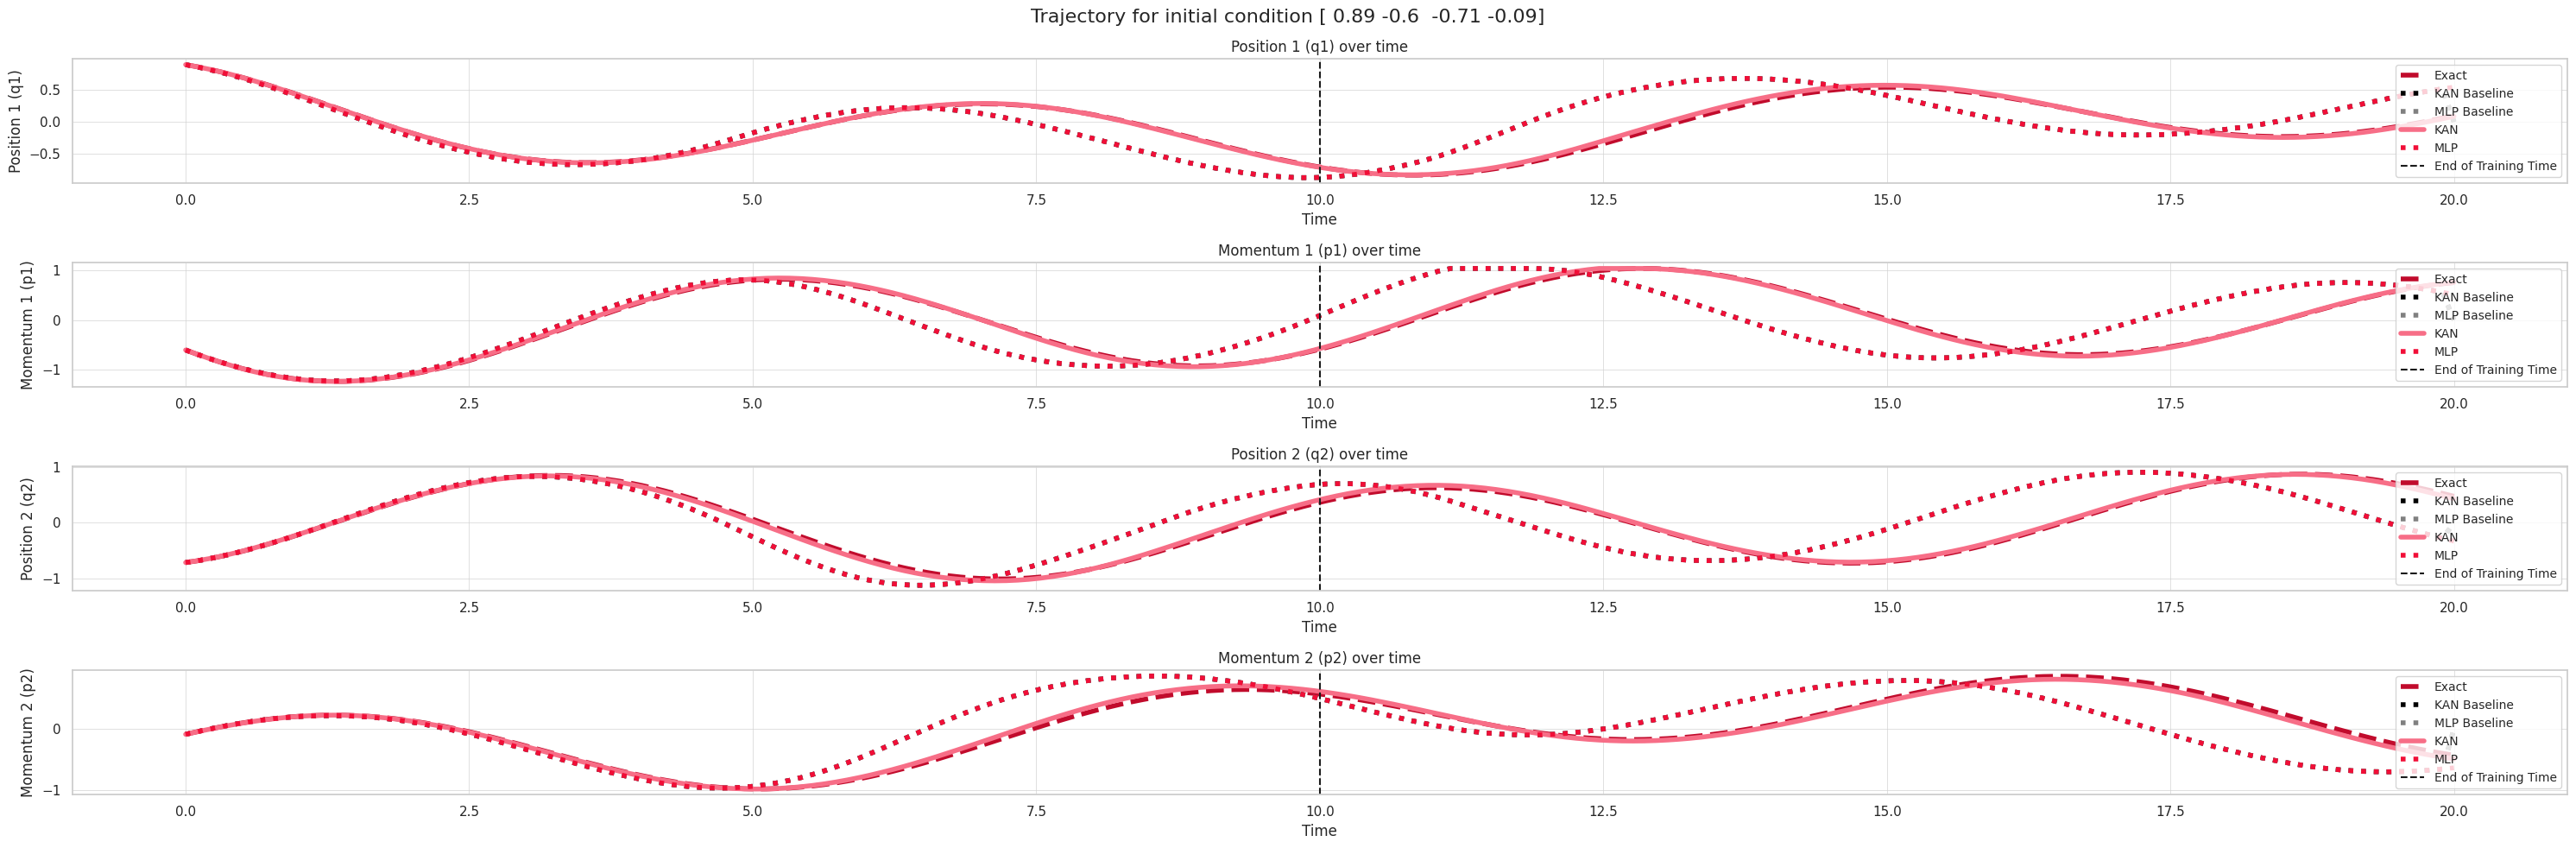

100%|██████████| 199/199 [00:22<00:00,  8.88it/s]


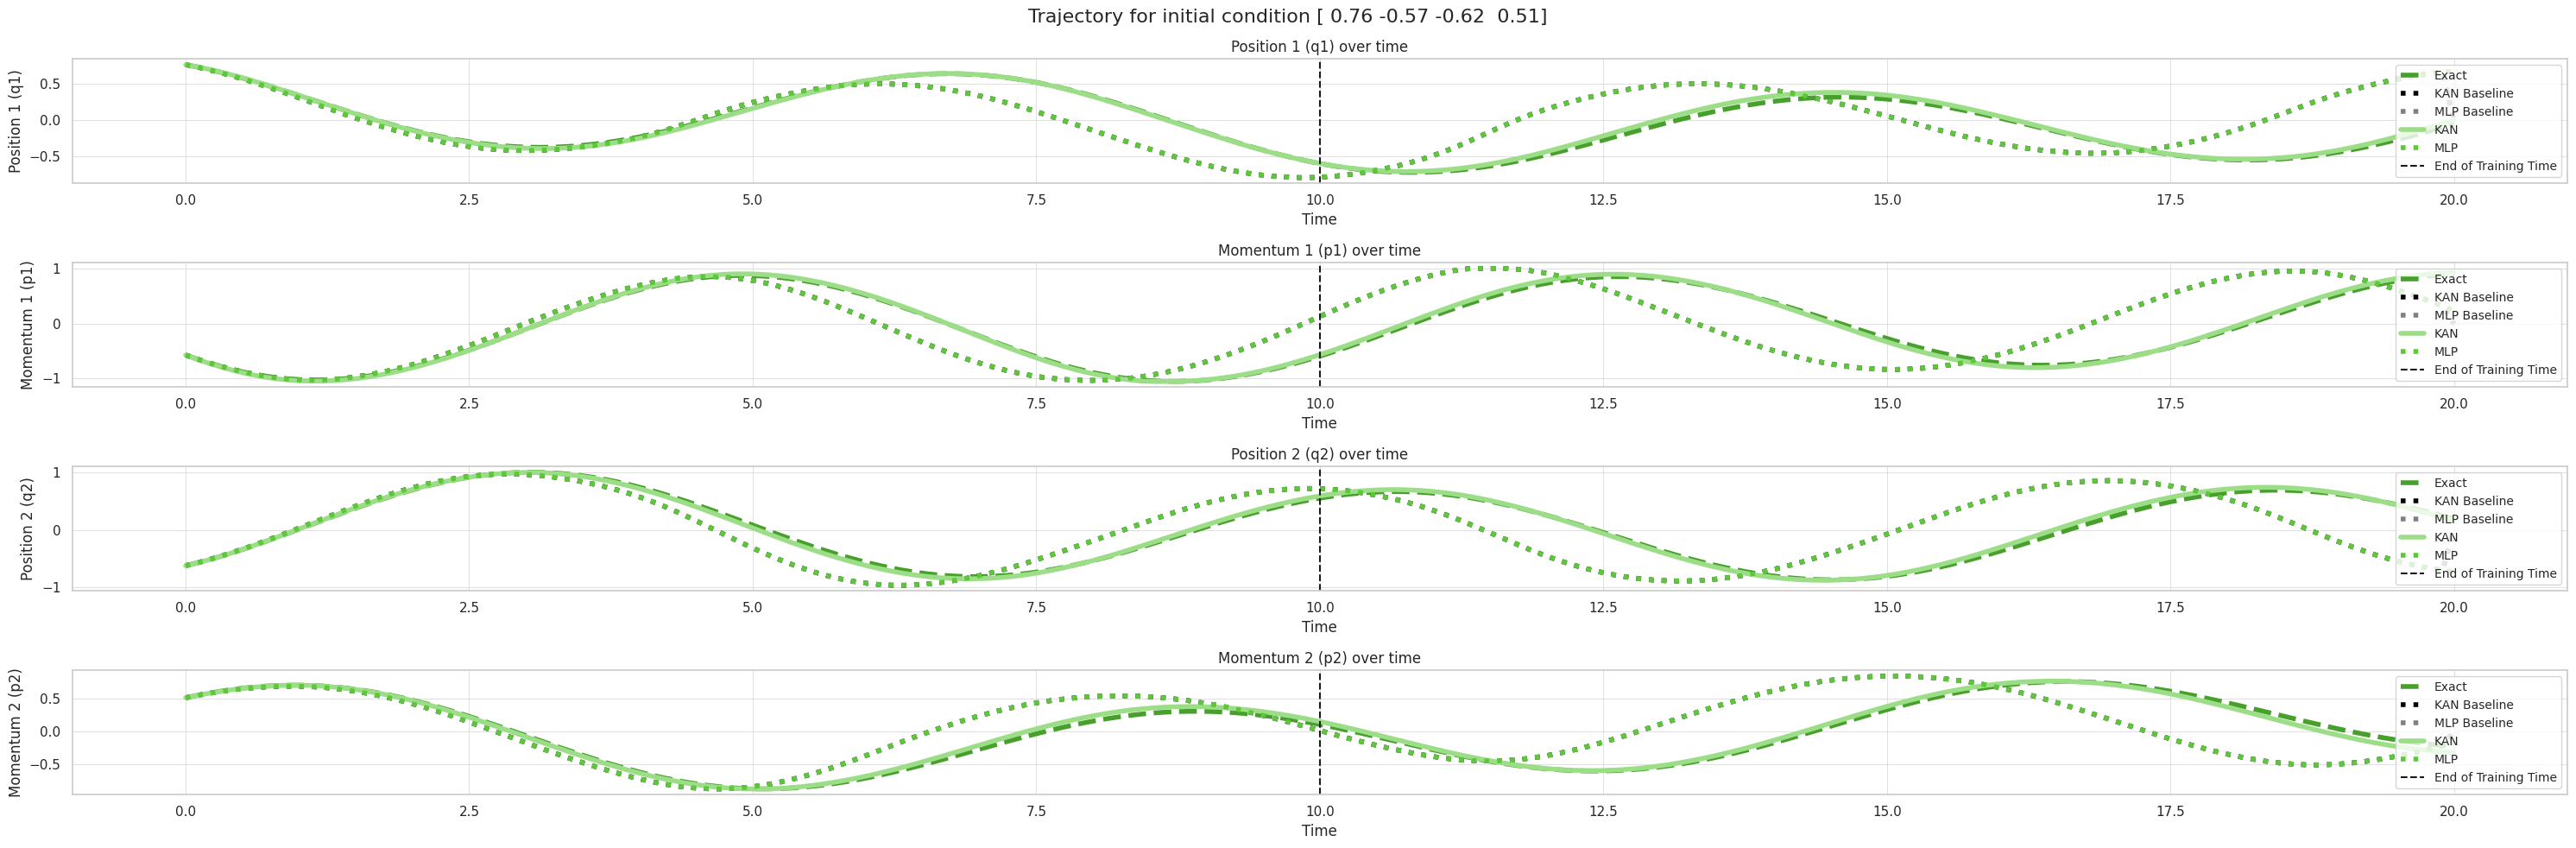

100%|██████████| 199/199 [00:21<00:00,  9.18it/s]


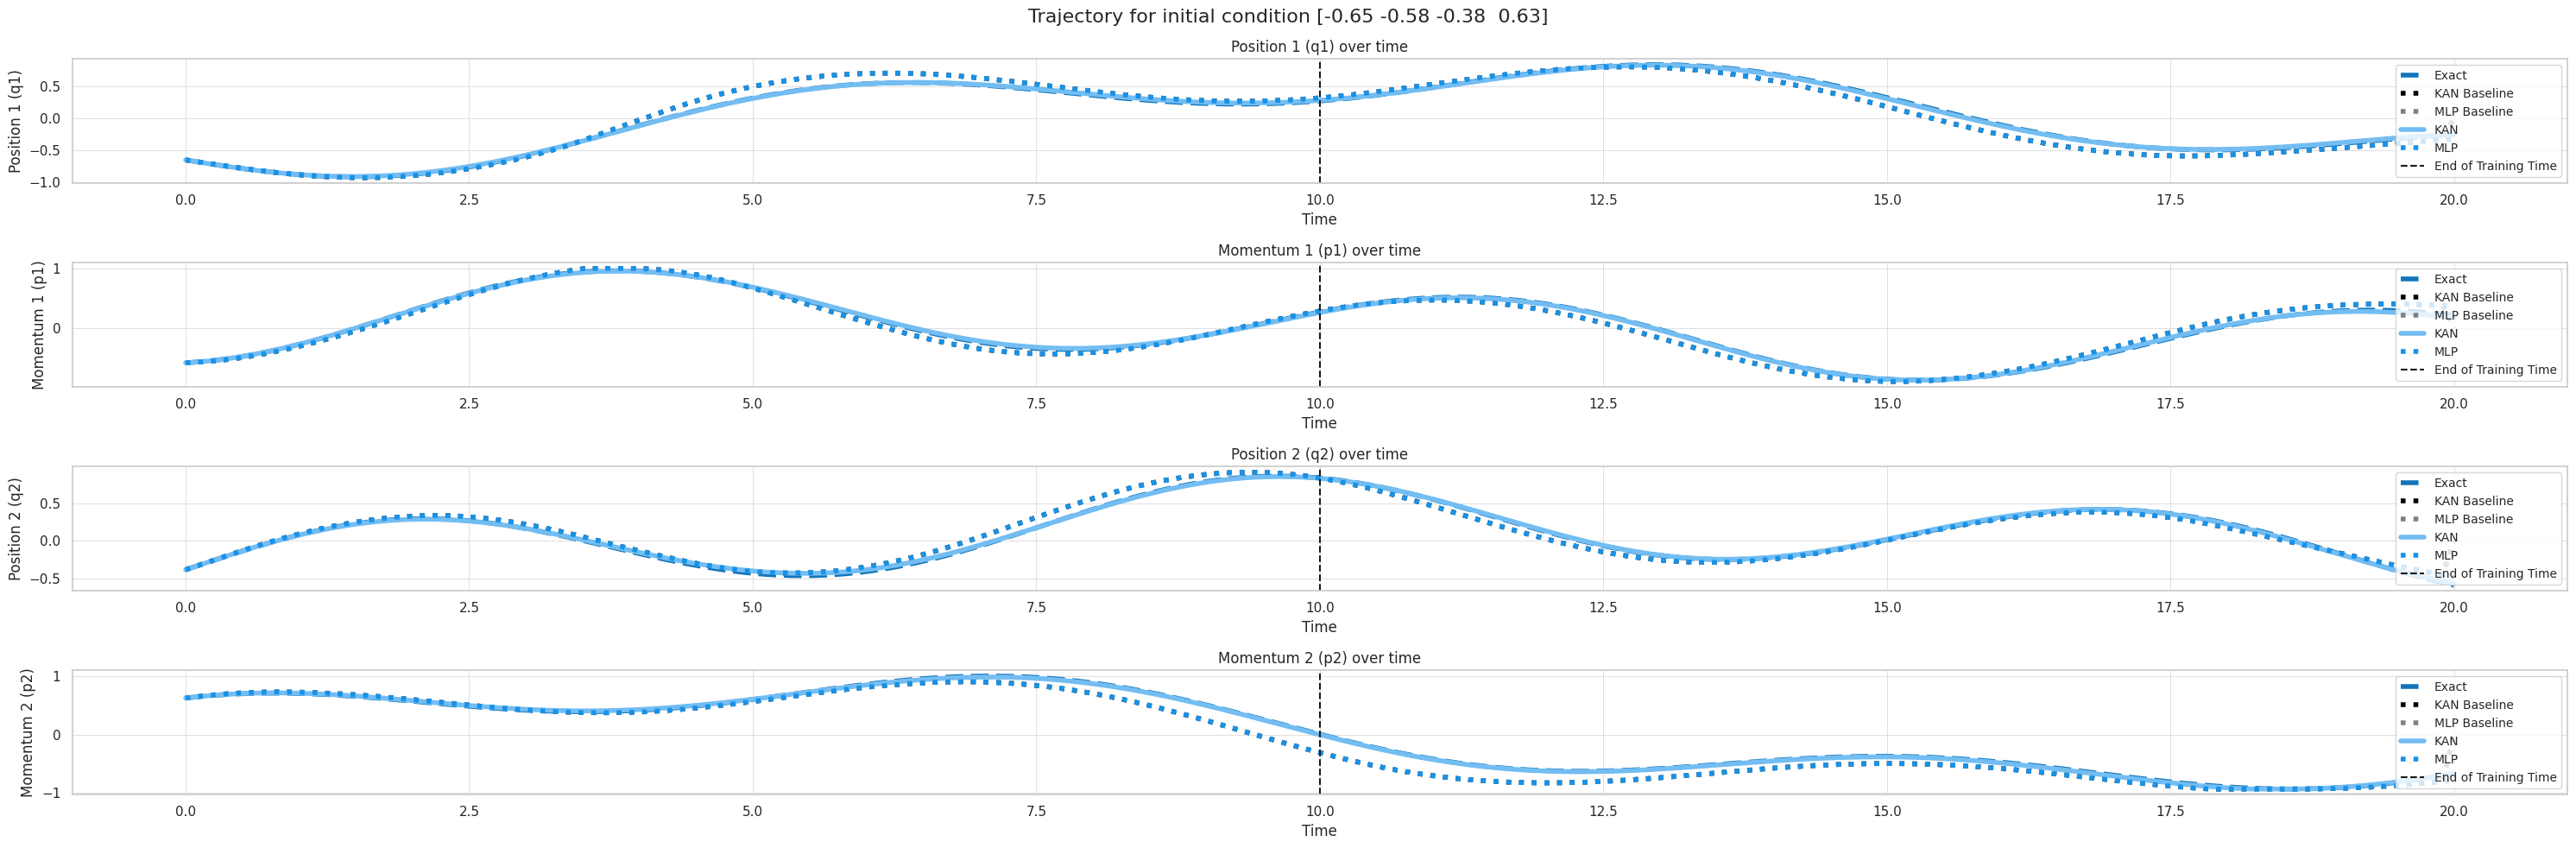

In [2]:
from tqdm import tqdm
sns.set_theme(style="whitegrid")

tmax = 20.0
t_vis = np.linspace(0, tmax, 200)

num_trajectories = 3
initial_states_vis = np.round(np.random.uniform(-1, 1, (num_trajectories, 4)), 2)

palette = sns.color_palette("husl", num_trajectories)
colors_exact = [sns.set_hls_values(palette[i], l=0.4) for i in range(num_trajectories)]
colors_kan = [sns.set_hls_values(palette[i], l=0.7) for i in range(num_trajectories)]
colors_mlp = [sns.set_hls_values(palette[i], l=0.5) for i in range(num_trajectories)]

def plot_trajectory(init_state, t_axis, color_exact, color_kan, color_mlp):
    solution_vis = odeint(system_dynamics, init_state, t_axis)
    X_test = tf.convert_to_tensor(solution_vis, dtype=tf.float32)
    #predictions_mlp = model_mlp.predict(X_test)
    #predictions_kan = model_kan.predict(X_test)
    
    predicted_trajectory_baseline_mlp = np.zeros_like(solution_vis)
    predicted_trajectory_baseline_kan = np.zeros_like(solution_vis)
    predicted_trajectory_mlp = np.zeros_like(solution_vis)
    predicted_trajectory_kan = np.zeros_like(solution_vis)
    
    predicted_trajectory_baseline_mlp[0] = solution_vis[0]
    predicted_trajectory_baseline_kan[0] = solution_vis[0]
    predicted_trajectory_mlp[0] = solution_vis[0]
    predicted_trajectory_kan[0] = solution_vis[0]
    m, M = np.min(solution_vis), np.max(solution_vis)
    for j in tqdm(range(1, len(solution_vis))):
        predicted_trajectory_baseline_mlp[j] = predicted_trajectory_baseline_mlp[j-1] + model_mlp_baseline.predict(predicted_trajectory_baseline_mlp[j-1: j], verbose=0)
        predicted_trajectory_baseline_mlp = np.clip(predicted_trajectory_mlp, m, M)
        
        predicted_trajectory_baseline_kan[j] = predicted_trajectory_baseline_kan[j-1] + model_kan_baseline.predict(predicted_trajectory_baseline_kan[j-1: j], verbose=0)
        predicted_trajectory_baseline_kan = np.clip(predicted_trajectory_mlp, m, M)

        predicted_trajectory_mlp[j] = predicted_trajectory_mlp[j-1] + model_mlp.predict(predicted_trajectory_mlp[j-1: j], verbose=0)
        predicted_trajectory_mlp = np.clip(predicted_trajectory_mlp, m, M)
        
        predicted_trajectory_kan[j] = predicted_trajectory_kan[j-1] + model_kan.predict(predicted_trajectory_kan[j-1: j], verbose=0)
        predicted_trajectory_kan = np.clip(predicted_trajectory_kan, m, M)

    fig, axs = plt.subplots(4, 1, figsize=(30, 10))
    fig.suptitle(f'Trajectory for initial condition {init_state}', fontsize=16)

    variables = ['Position 1 (q1)', 'Momentum 1 (p1)', 'Position 2 (q2)', 'Momentum 2 (p2)']
    
    for i in range(4):
        axs[i].plot(t_axis, solution_vis[:, i], linestyle="dashed", color=color_exact, label="Exact", linewidth=4)
        axs[i].plot(t_axis, predicted_trajectory_baseline_kan[:, i], linestyle="dotted", color='black', label="KAN Baseline", linewidth=4)
        axs[i].plot(t_axis, predicted_trajectory_baseline_mlp[:, i], linestyle="dotted", color='grey', label="MLP Baseline", linewidth=4)
        axs[i].plot(t_axis, predicted_trajectory_kan[:, i], color=color_kan, label="KAN", linewidth=4)
        axs[i].plot(t_axis, predicted_trajectory_mlp[:, i], linestyle="dotted", color=color_mlp, label="MLP", linewidth=4)
        axs[i].axvline(x=10, color='k', linestyle='--', label='End of Training Time')
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel(variables[i])
        axs[i].legend(loc='upper right', fontsize='small')
        axs[i].set_title(f'{variables[i]} over time')
        axs[i].grid(color='lightgrey', linestyle='-', linewidth=0.5)

    plt.tight_layout()
    plt.show()

for i, init_state in enumerate(initial_states_vis):
    plot_trajectory(init_state, t_vis, colors_exact[i], colors_kan[i], colors_mlp[i])

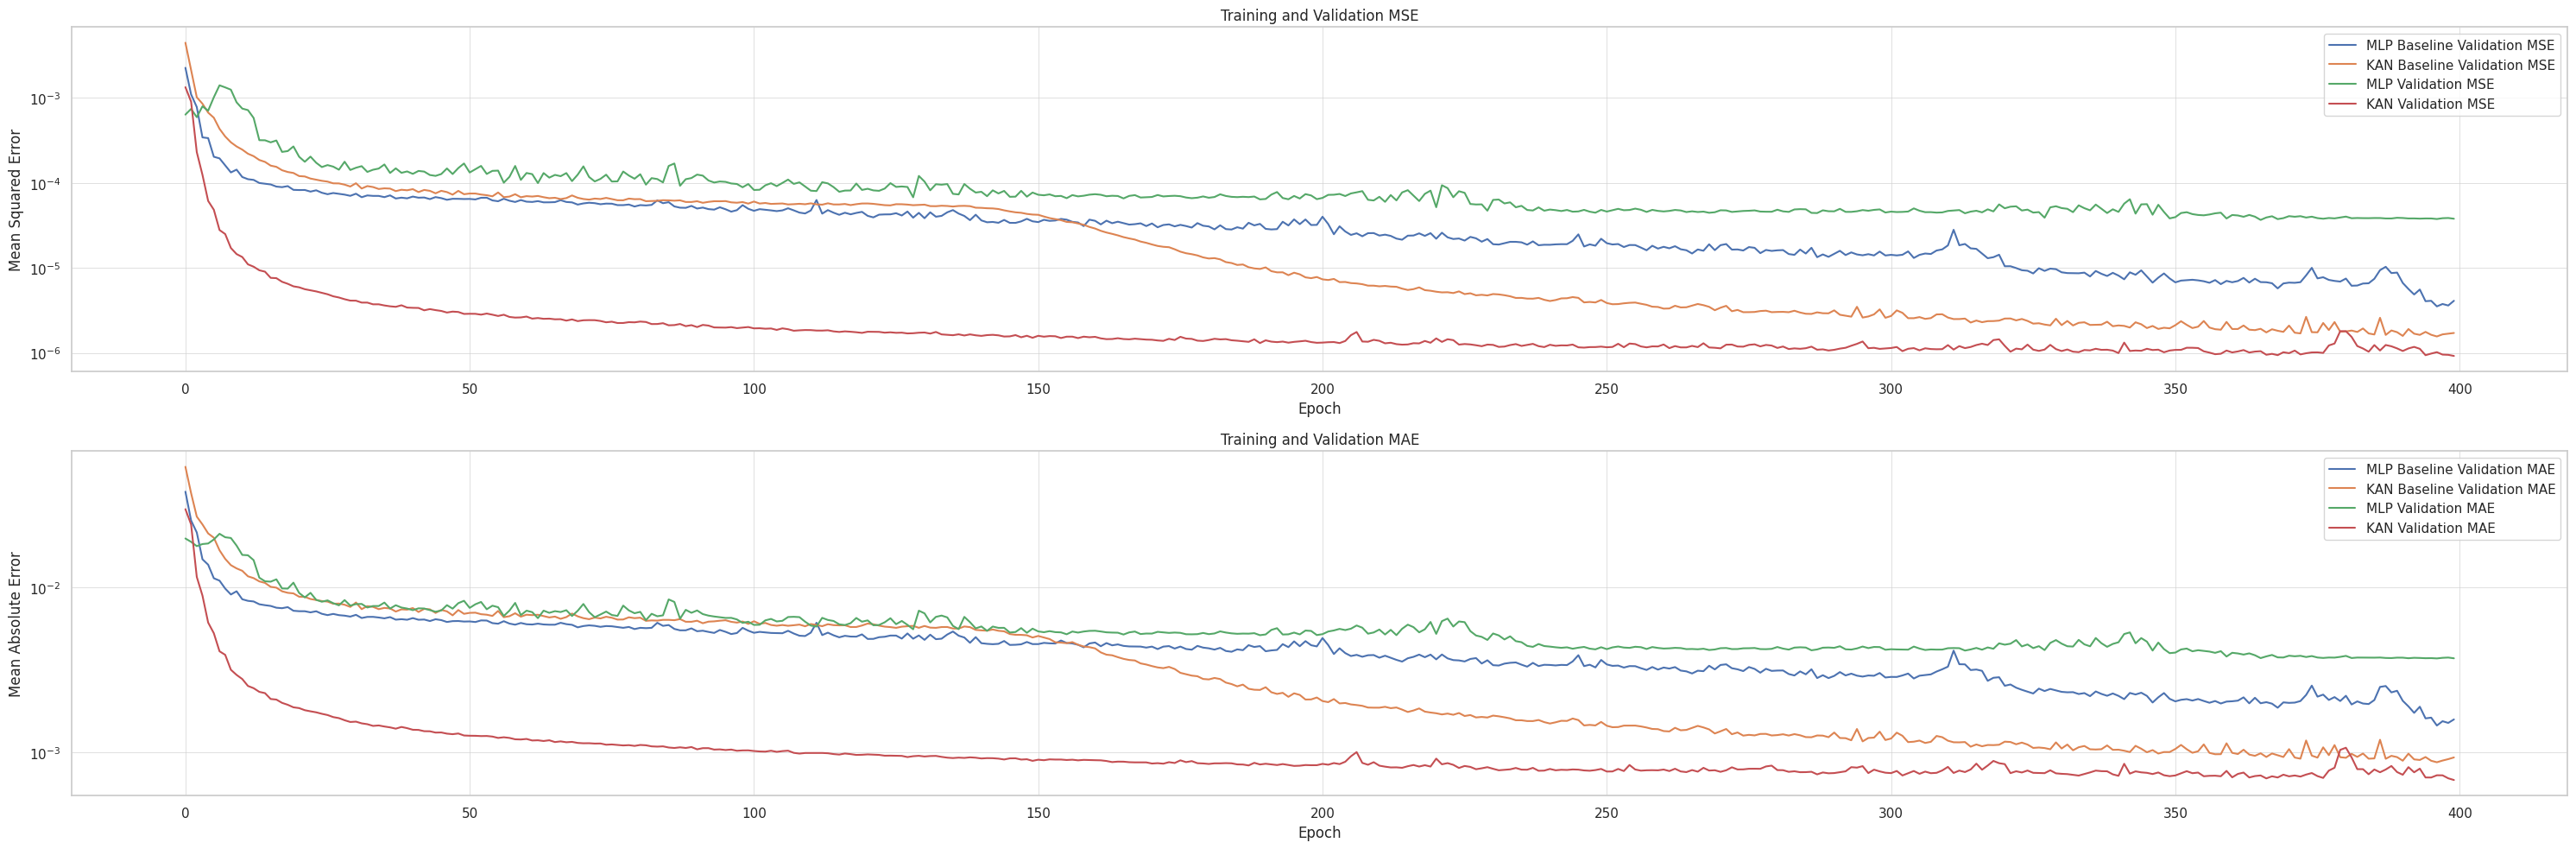

In [3]:
plt.figure(figsize=(30, 10))

plt.subplot(2, 1, 1)
plt.plot(history_mlp_baseline.history['val_loss'], label='MLP Baseline Validation MSE')
plt.plot(history_kan_baseline.history['val_loss'], label='KAN Baseline Validation MSE')
plt.plot(history_mlp.history['val_loss'], label='MLP Validation MSE')
plt.plot(history_kan.history['val_loss'], label='KAN Validation MSE')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)

plt.subplot(2, 1, 2)
plt.plot(history_mlp_baseline.history['val_mae'], label='MLP Baseline Validation MAE')
plt.plot(history_kan_baseline.history['val_mae'], label='KAN Baseline Validation MAE')
plt.plot(history_mlp.history['val_mae'], label='MLP Validation MAE')
plt.plot(history_kan.history['val_mae'], label='KAN Validation MAE')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

## Second Training: This second training was performed using **6 trajectories** in the dataset.


In [4]:
import numpy as np
import tensorflow as tf
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from tfkan.layers import DenseKAN
from keras.optimizers import legacy as legacy_optimizers
import seaborn as sns


# System parameters
masses = [1.0, 1.5]  
spring_constants = [1.0, 1.2] 
damping = 0.1  
simulation_time = 10.0 
dt = simulation_time / 100  
num_steps = 100 
num_trajectories = 6 

# Definition of matrices J and R
J = np.array([[0, 1, 0, 0], 
              [-1, 0, 1, 0], 
              [0, -1, 0, 1], 
              [0, 0, -1, 0]])

# Resistance matrix R is dynamically computed based on the state x
def R(x):
    return np.array([[0, 0, 0, 0],
                     [0, damping * x[1]**2 / masses[0]**2, 0, 0],
                     [0, 0, 0, 0],
                     [0, 0, 0, damping * x[3]**2 / masses[1]**2]])

M = np.diag([spring_constants[0] / 2, 1 / (2 * masses[0]), spring_constants[1] / 2, 1 / (2 * masses[1])])

def hamiltonian(x):
    return x.T @ M @ x

def grad_hamiltonian(x):
    return M @ x

def system_dynamics(x, t):
    grad_H = grad_hamiltonian(x)
    return (J - R(x)) @ grad_H

# Generate a trajectory based on initial state
def generate_trajectory(initial_state):
    t = np.linspace(0, simulation_time, num_steps)
    return odeint(system_dynamics, initial_state, t)

# Generate multiple trajectories for training
    
def get_data():
    all_X = []
    all_y = []
    for _ in range(num_trajectories):
        initial_state = np.round(np.random.uniform(-1, 1, 4), 2)  # Random initial state
        trajectory = generate_trajectory(initial_state)
        X = trajectory[:-1]  
        y = trajectory[1:] - trajectory[:-1] 
        all_X.append(X)
        all_y.append(y)
    
    # Combine all trajectories into one dataset
    X = np.concatenate(all_X)
    y = np.concatenate(all_y)

    # Shuffle the dataset to ensure randomness during training
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    # Convert the data to TensorFlow tensors
    X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
    y_tf = tf.convert_to_tensor(y, dtype=tf.float32)
    
    return X_tf, y_tf

X_tf, y_tf = get_data()
X_val_tf, y_val_tf = get_data()

class HamiltonianNN_MLP(tf.keras.Model):
    def __init__(self, n=4, num_subdomains=4):
        super(HamiltonianNN_MLP, self).__init__()
        self.n = n
        self.num_subdomains = num_subdomains
        
        # Define sub-networks for each subdomain 
        self.subdomain_networks = []
        for _ in range(num_subdomains):
            subdomain_net = {
                'Q': self.create_network(n * (n + 1) // 2),
                'W': self.create_network(n * (n + 1) // 2),
                'J': self.create_network(n * (n - 1) // 2)
            }
            self.subdomain_networks.append(subdomain_net)

    # Create a simple fully connected neural network
    def create_network(self, output_dim):
        return tf.keras.Sequential([
            tf.keras.layers.Dense(100, activation='tanh', input_shape=(self.n,)),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.Dense(output_dim)
        ])
    
    # Window function to determine subdomain weights based on input 
    def window_function(self, x, subdomain):
        centers = tf.linspace(-1.0, 1.0, self.num_subdomains)
        dist = tf.reduce_sum(tf.square(x - centers[subdomain]), axis=-1)
        scale = 1.0 / (0.1 + tf.exp(-dist))  # Adjust scale based on distance
        return tf.exp(-dist / (2.0 * scale))
    
    # Method to convert vector v to a symmetric matrix V (upper triangular part)
    def vtu(self, v):
        n = self.n
        batch_size = tf.shape(v)[0]
        V = tf.zeros((batch_size, n, n), dtype=tf.float32)
        idx = tf.repeat(tf.expand_dims(tf.constant([[i, j] for i in range(n) for j in range(i, n)]), 0), batch_size, axis=0)
        batch_idx = tf.repeat(tf.expand_dims(tf.range(batch_size), 1), idx.shape[1], axis=1)
        idx = tf.stack([batch_idx, idx[:,:,0], idx[:,:,1]], axis=-1)
        V = tf.tensor_scatter_nd_update(V, idx, v)
        return V
    
    # Method to convert vector v to a skew-symmetric matrix V (strictly upper part)
    def vtsu(self, v):
        n = self.n
        batch_size = tf.shape(v)[0]
        V = tf.zeros((batch_size, n, n), dtype=tf.float32)
        idx = tf.repeat(tf.expand_dims(tf.constant([[i, j] for i in range(n) for j in range(i+1, n)]), 0), batch_size, axis=0)
        batch_idx = tf.repeat(tf.expand_dims(tf.range(batch_size), 1), idx.shape[1], axis=1)
        idx = tf.stack([batch_idx, idx[:,:,0], idx[:,:,1]], axis=-1)
        V = tf.tensor_scatter_nd_update(V, idx, v)
        return V
    
    # Compute gradient of the Hamiltonian
    def grad_hamiltonian(self, x, Q):
        return tf.matmul(Q, x[:, :, tf.newaxis])[:, :, 0]

    # Forward pass of the model, computing outputs based on each subdomain
    def call(self, x):
        batch_size = tf.shape(x)[0]
        outputs = []
        weights = []
        
        # Iterate over each subdomain
        for i, subdomain_net in enumerate(self.subdomain_networks):
            window = self.window_function(x, i)
            
            # Calculate the Q, W, and J matrices for this subdomain
            theta_Q = subdomain_net['Q'](x)
            theta_W = subdomain_net['W'](x)
            theta_J = subdomain_net['J'](x)
            
            Q = tf.matmul(self.vtu(theta_Q), tf.transpose(self.vtu(theta_Q), perm=[0, 2, 1]))
            W = tf.matmul(self.vtu(theta_W), tf.transpose(self.vtu(theta_W), perm=[0, 2, 1]))
            J_pred = tf.matmul(self.vtsu(theta_J), tf.transpose(self.vtsu(theta_J), perm=[0, 2, 1])) - \
                     tf.matmul(tf.transpose(self.vtsu(theta_J), perm=[0, 2, 1]), self.vtsu(theta_J))
            
            I = tf.eye(self.n, batch_shape=[batch_size])
            R_pred = tf.matmul(tf.matmul(I, W), I)
            
            grad_H = self.grad_hamiltonian(x, Q)
            output = tf.matmul(J_pred - R_pred, grad_H[:, :, tf.newaxis])[:, :, 0]
            outputs.append(window[:, tf.newaxis] * output)
            weights.append(window[:, tf.newaxis])

        # Combine outputs from all subdomains
        outputs_sum = tf.add_n(outputs)
        weights_sum = tf.add_n(weights)
        final_output = outputs_sum / (weights_sum + 1e-6) 
        return final_output

class HamiltonianNN_KAN(tf.keras.Model):
    def __init__(self, n=4, num_subdomains=4):
        super(HamiltonianNN_KAN, self).__init__()
        self.n = n
        self.num_subdomains = num_subdomains
        
        # Define sub-networks for each subdomain
        self.subdomain_networks = []
        for _ in range(num_subdomains):
            subdomain_net = {
                'Q': self.create_network(n * (n + 1) // 2),
                'W': self.create_network(n * (n + 1) // 2),
                'J': self.create_network(n * (n - 1) // 2)
            }
            self.subdomain_networks.append(subdomain_net)
    
    def create_network(self, output_dim):
        return tf.keras.Sequential([
            DenseKAN(4, input_shape=(self.n,)),
            DenseKAN(4),
            DenseKAN(output_dim)
        ])
    
    # Window function to determine subdomain weights based on input x
    def window_function(self, x, subdomain):
        centers = tf.linspace(-1.0, 1.0, self.num_subdomains)
        dist = tf.reduce_sum(tf.square(x - centers[subdomain]), axis=-1)
        scale = 1.0 / (0.1 + tf.exp(-dist))
        return tf.exp(-dist / (2.0 * scale))
    
    # Method to convert vector v to a symmetric matrix V (upper triangular)
    def vtu(self, v):
        n = self.n
        batch_size = tf.shape(v)[0]
        V = tf.zeros((batch_size, n, n), dtype=tf.float32)
        idx = tf.repeat(tf.expand_dims(tf.constant([[i, j] for i in range(n) for j in range(i, n)]), 0), batch_size, axis=0)
        batch_idx = tf.repeat(tf.expand_dims(tf.range(batch_size), 1), idx.shape[1], axis=1)
        idx = tf.stack([batch_idx, idx[:,:,0], idx[:,:,1]], axis=-1)
        V = tf.tensor_scatter_nd_update(V, idx, v)
        return V
    
    # Method to convert vector v to a skew-symmetric matrix V (strictly upper)
    def vtsu(self, v):
        n = self.n
        batch_size = tf.shape(v)[0]
        V = tf.zeros((batch_size, n, n), dtype=tf.float32)
        idx = tf.repeat(tf.expand_dims(tf.constant([[i, j] for i in range(n) for j in range(i+1, n)]), 0), batch_size, axis=0)
        batch_idx = tf.repeat(tf.expand_dims(tf.range(batch_size), 1), idx.shape[1], axis=1)
        idx = tf.stack([batch_idx, idx[:,:,0], idx[:,:,1]], axis=-1)
        V = tf.tensor_scatter_nd_update(V, idx, v)
        return V
    
    # Compute gradient of the Hamiltonian
    def grad_hamiltonian(self, x, Q):
        return tf.matmul(Q, x[:, :, tf.newaxis])[:, :, 0]
    
    # Forward pass of the model, computing outputs based on each subdomain
    def call(self, x):
        batch_size = tf.shape(x)[0]
        outputs = []
        weights = []
        
        # Iterate over each subdomain
        for i, subdomain_net in enumerate(self.subdomain_networks):
            window = self.window_function(x, i)
            
            # Calculate the Q, W, and J matrices for this subdomain
            theta_Q = subdomain_net['Q'](x)
            theta_W = subdomain_net['W'](x)
            theta_J = subdomain_net['J'](x)
            
            Q = tf.matmul(self.vtu(theta_Q), tf.transpose(self.vtu(theta_Q), perm=[0, 2, 1]))
            W = tf.matmul(self.vtu(theta_W), tf.transpose(self.vtu(theta_W), perm=[0, 2, 1]))
            J_pred = tf.matmul(self.vtsu(theta_J), tf.transpose(self.vtsu(theta_J), perm=[0, 2, 1])) - \
                     tf.matmul(tf.transpose(self.vtsu(theta_J), perm=[0, 2, 1]), self.vtsu(theta_J))
            
            I = tf.eye(self.n, batch_shape=[batch_size])
            R_pred = tf.matmul(tf.matmul(I, W), I)
            
            grad_H = self.grad_hamiltonian(x, Q)
            output = tf.matmul(J_pred - R_pred, grad_H[:, :, tf.newaxis])[:, :, 0]
            outputs.append(window[:, tf.newaxis] * output)
            weights.append(window[:, tf.newaxis])
        
        # Combine outputs from all subdomains
        outputs_sum = tf.add_n(outputs)
        weights_sum = tf.add_n(weights)
        final_output = outputs_sum / (weights_sum + 1e-6)
        return final_output

# Creation of MLP and KAN models
model_mlp_baseline = tf.keras.Sequential([
            tf.keras.layers.Dense(100, activation='tanh', input_shape=(4,)),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.Dense(4)
        ])
model_kan_baseline = tf.keras.Sequential([
            DenseKAN(4, input_shape=(4,)),
            DenseKAN(4),
            DenseKAN(4)
        ])
model_mlp = HamiltonianNN_MLP()
model_kan = HamiltonianNN_KAN()

# Define training parameters
batch_size = 32
epochs = 400
lr = .001

# Calculate the number of steps per epoch and total steps
steps_per_epoch = math.ceil(len(X_tf) / batch_size)
total_steps = steps_per_epoch * epochs

# Create a cosine decay learning rate schedule
lr_schedule = CosineDecay(
    initial_learning_rate=lr,
    decay_steps=total_steps,
    alpha=0.01  # Final learning rate will be alpha * initial_learning_rate
)

use_scheduler = False

# Optimizers for both models using the cosine decay learning rate schedule
optimizer_mlp_baseline = legacy_optimizers.Adam(learning_rate=lr_schedule if use_scheduler else lr)
optimizer_kan_baseline = legacy_optimizers.Adam(learning_rate=lr_schedule if use_scheduler else lr)
optimizer_mlp = legacy_optimizers.Adam(learning_rate=lr_schedule if use_scheduler else lr)
optimizer_kan = legacy_optimizers.Adam(learning_rate=lr_schedule if use_scheduler else lr)

# Compile models with MSE loss and MAE as an additional metric
model_mlp_baseline.compile(optimizer=optimizer_mlp_baseline, loss='mse', metrics=['mae'])
model_kan_baseline.compile(optimizer=optimizer_kan_baseline, loss='mse', metrics=['mae'])
model_mlp.compile(optimizer=optimizer_mlp, loss='mse', metrics=['mae'])
model_kan.compile(optimizer=optimizer_kan, loss='mse', metrics=['mae'])

# Build the models with a dummy input
dummy_input = tf.random.normal((1, 4))
_ = model_mlp_baseline(dummy_input)
_ = model_kan_baseline(dummy_input)
_ = model_mlp(dummy_input)
_ = model_kan(dummy_input)

# Train all models with the cosine decay learning rate schedule
validation_data = (X_val_tf, y_val_tf)
history_mlp_baseline = model_mlp_baseline.fit(
    X_tf, y_tf,
    validation_data=validation_data,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)
history_kan_baseline = model_kan_baseline.fit(
    X_tf, y_tf,
    validation_data=validation_data,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)
history_kan = model_kan.fit(
    X_tf, y_tf,
    validation_data=validation_data,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)
history_mlp = model_mlp.fit(
    X_tf, y_tf,
    validation_data=validation_data,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)


  0%|          | 0/199 [00:00<?, ?it/s]

100%|██████████| 199/199 [00:26<00:00,  7.63it/s]


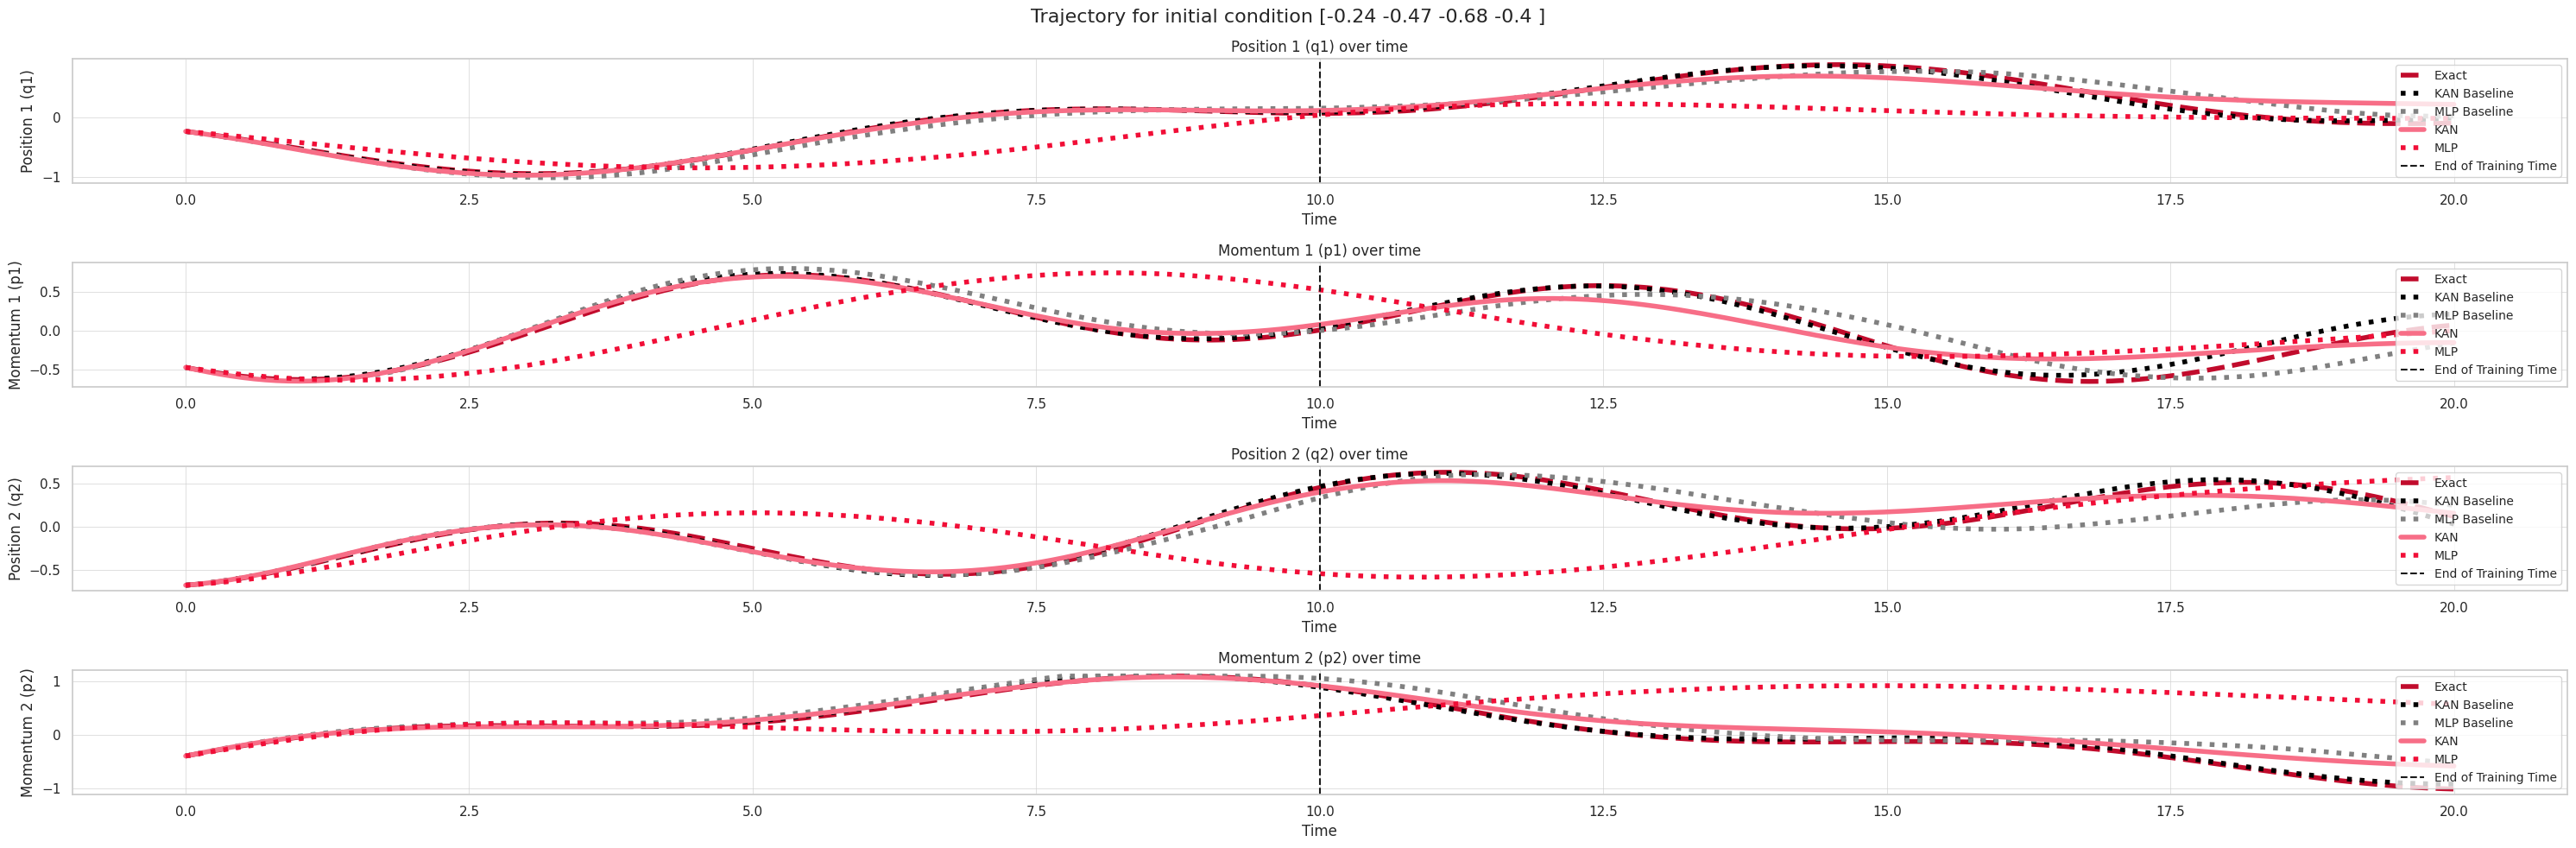

100%|██████████| 199/199 [00:21<00:00,  9.42it/s]


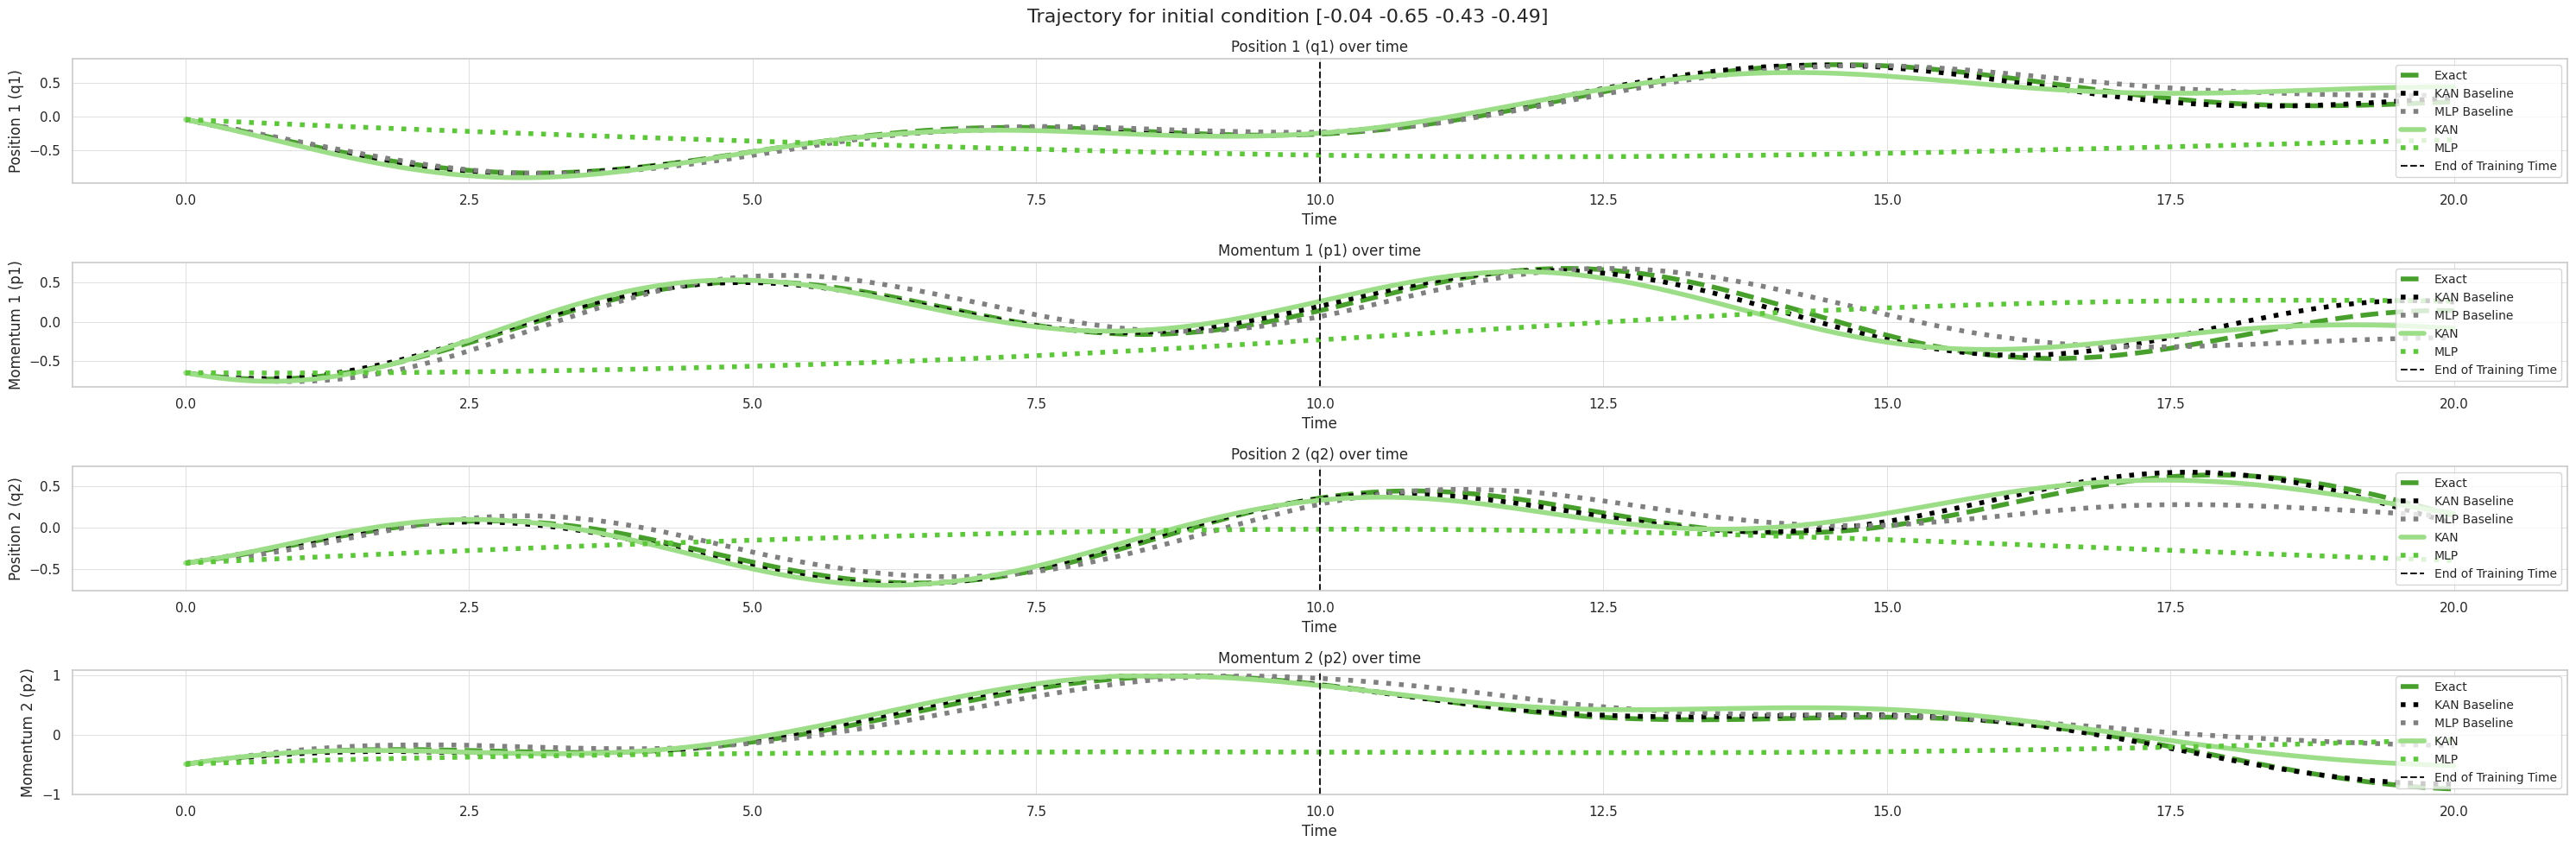

100%|██████████| 199/199 [00:22<00:00,  8.69it/s]


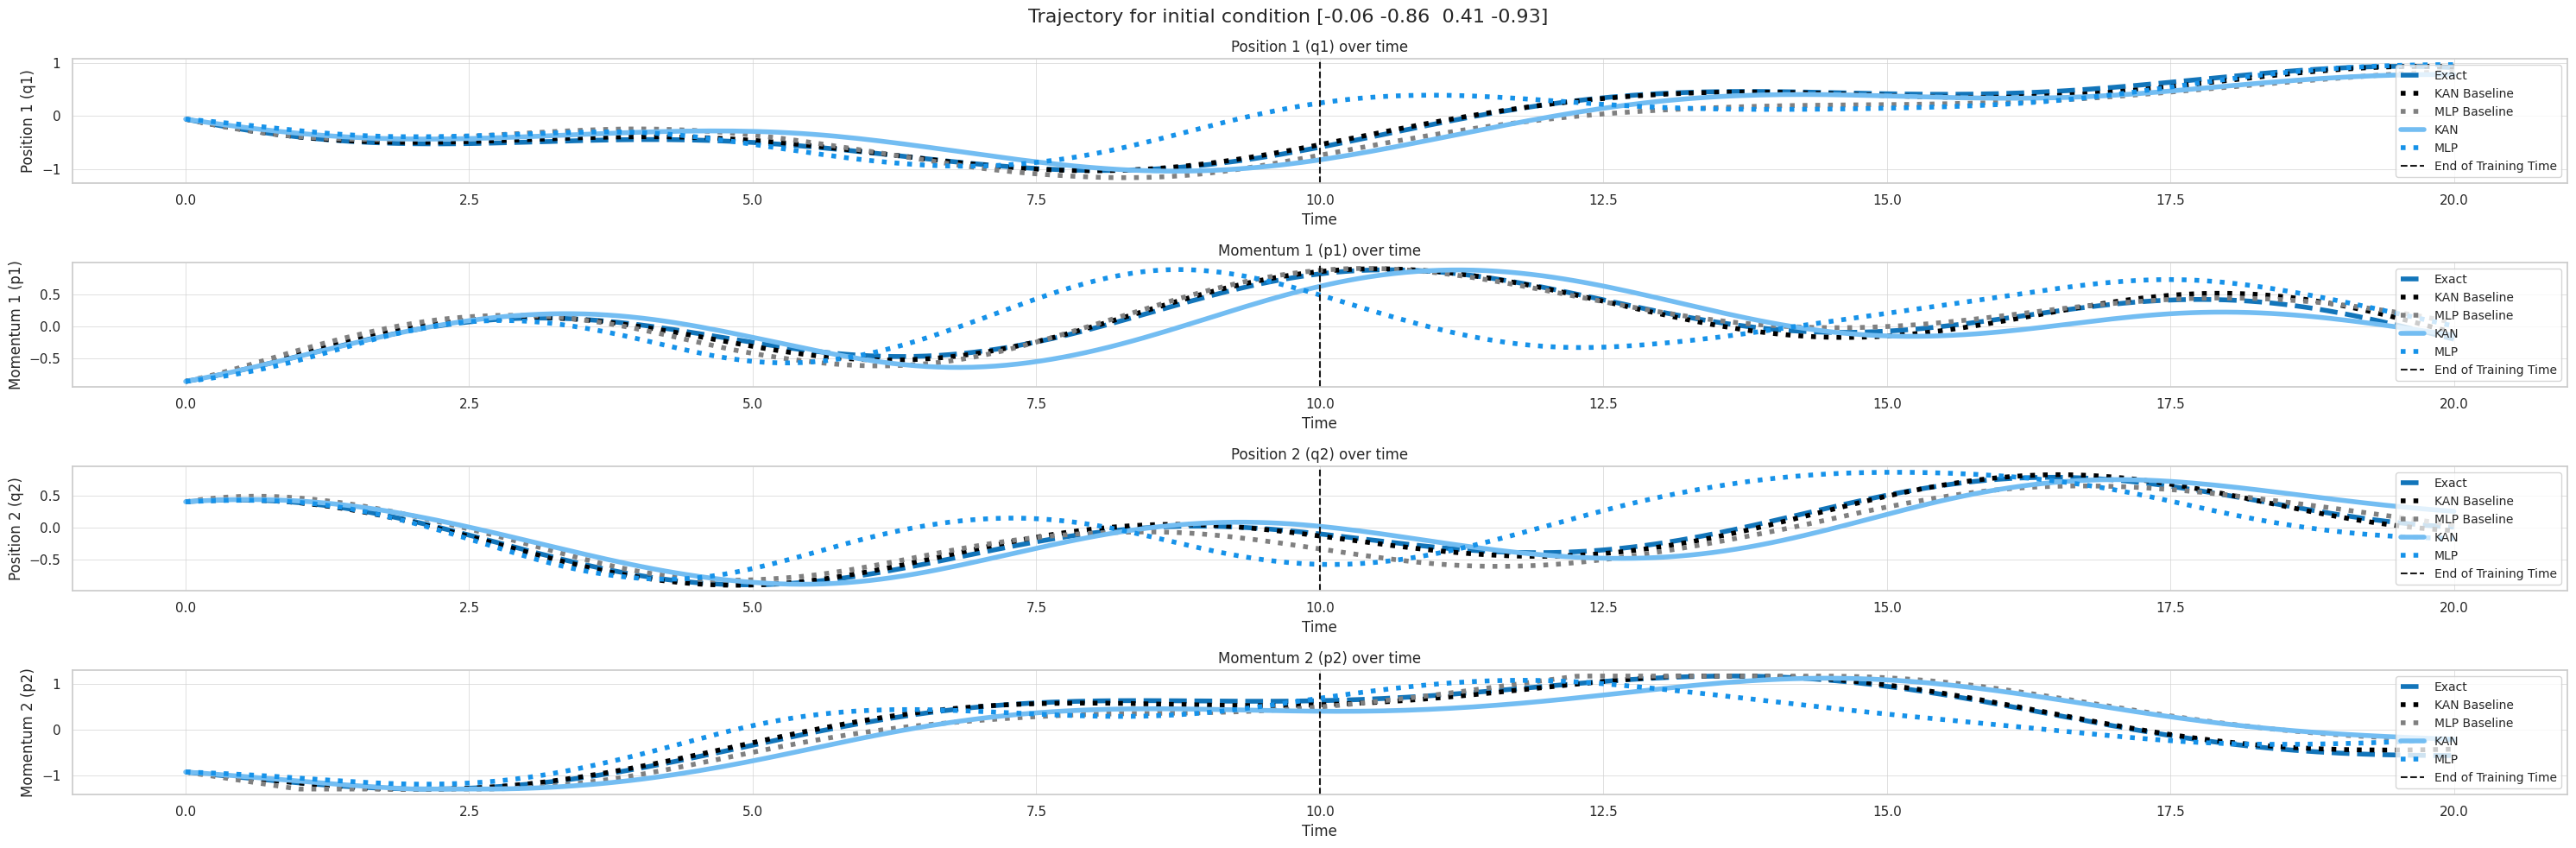

In [5]:
from tqdm import tqdm
sns.set_theme(style="whitegrid")

tmax = 20.0
t_vis = np.linspace(0, tmax, 200)

num_trajectories = 3
initial_states_vis = np.round(np.random.uniform(-1, 1, (num_trajectories, 4)), 2)

palette = sns.color_palette("husl", num_trajectories)
colors_exact = [sns.set_hls_values(palette[i], l=0.4) for i in range(num_trajectories)]
colors_kan = [sns.set_hls_values(palette[i], l=0.7) for i in range(num_trajectories)]
colors_mlp = [sns.set_hls_values(palette[i], l=0.5) for i in range(num_trajectories)]

def plot_trajectory(init_state, t_axis, color_exact, color_kan, color_mlp):
    solution_vis = odeint(system_dynamics, init_state, t_axis)
    X_test = tf.convert_to_tensor(solution_vis, dtype=tf.float32)
    #predictions_mlp = model_mlp.predict(X_test)
    #predictions_kan = model_kan.predict(X_test)
    
    predicted_trajectory_baseline_mlp = np.zeros_like(solution_vis)
    predicted_trajectory_baseline_kan = np.zeros_like(solution_vis)
    predicted_trajectory_mlp = np.zeros_like(solution_vis)
    predicted_trajectory_kan = np.zeros_like(solution_vis)
    
    predicted_trajectory_baseline_mlp[0] = solution_vis[0]
    predicted_trajectory_baseline_kan[0] = solution_vis[0]
    predicted_trajectory_mlp[0] = solution_vis[0]
    predicted_trajectory_kan[0] = solution_vis[0]
    m, M = np.min(solution_vis), np.max(solution_vis)
    for j in tqdm(range(1, len(solution_vis))):
        predicted_trajectory_baseline_mlp[j] = predicted_trajectory_baseline_mlp[j-1] + model_mlp_baseline.predict(predicted_trajectory_baseline_mlp[j-1: j], verbose=0)
        predicted_trajectory_baseline_mlp = np.clip(predicted_trajectory_baseline_mlp, m, M)
        predicted_trajectory_baseline_kan[j] = predicted_trajectory_baseline_kan[j-1] + model_kan_baseline.predict(predicted_trajectory_baseline_kan[j-1: j], verbose=0)
        predicted_trajectory_baseline_kan = np.clip(predicted_trajectory_baseline_kan, m, M)
        predicted_trajectory_mlp[j] = predicted_trajectory_mlp[j-1] + model_mlp.predict(predicted_trajectory_mlp[j-1: j], verbose=0)
        predicted_trajectory_mlp = np.clip(predicted_trajectory_mlp, m, M)
        predicted_trajectory_kan[j] = predicted_trajectory_kan[j-1] + model_kan.predict(predicted_trajectory_kan[j-1: j], verbose=0)
        predicted_trajectory_kan = np.clip(predicted_trajectory_kan, m, M)

    fig, axs = plt.subplots(4, 1, figsize=(30, 10))
    fig.suptitle(f'Trajectory for initial condition {init_state}', fontsize=16)

    variables = ['Position 1 (q1)', 'Momentum 1 (p1)', 'Position 2 (q2)', 'Momentum 2 (p2)']
    
    for i in range(4):
        axs[i].plot(t_axis, solution_vis[:, i], linestyle="dashed", color=color_exact, label="Exact", linewidth=4)
        axs[i].plot(t_axis, predicted_trajectory_baseline_kan[:, i], linestyle="dotted", color='black', label="KAN Baseline", linewidth=4)
        axs[i].plot(t_axis, predicted_trajectory_baseline_mlp[:, i], linestyle="dotted", color='grey', label="MLP Baseline", linewidth=4)
        axs[i].plot(t_axis, predicted_trajectory_kan[:, i], color=color_kan, label="KAN", linewidth=4)
        axs[i].plot(t_axis, predicted_trajectory_mlp[:, i], linestyle="dotted", color=color_mlp, label="MLP", linewidth=4)
        axs[i].axvline(x=10, color='k', linestyle='--', label='End of Training Time')
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel(variables[i])
        axs[i].legend(loc='upper right', fontsize='small')
        axs[i].set_title(f'{variables[i]} over time')
        axs[i].grid(color='lightgrey', linestyle='-', linewidth=0.5)

    plt.tight_layout()
    plt.show()

for i, init_state in enumerate(initial_states_vis):
    plot_trajectory(init_state, t_vis, colors_exact[i], colors_kan[i], colors_mlp[i])

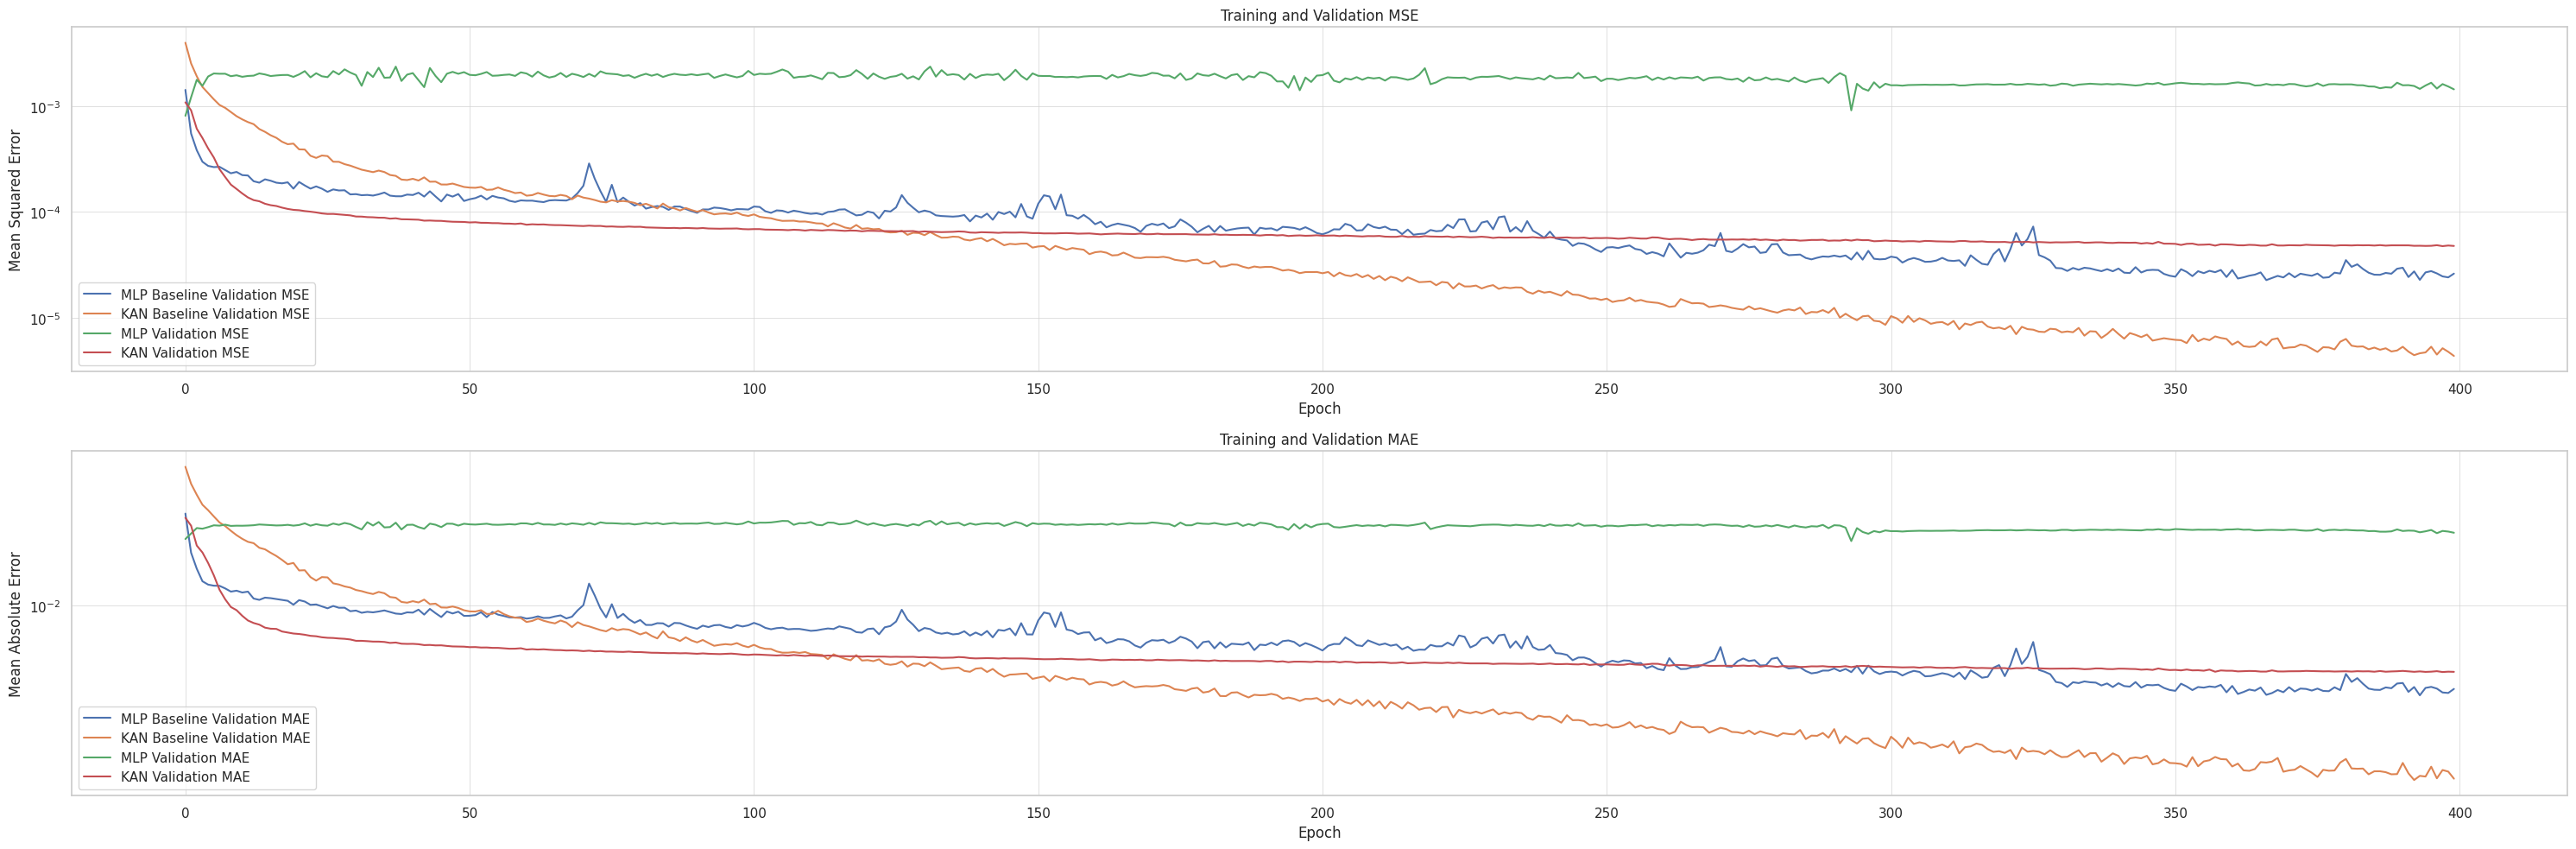

In [6]:
plt.figure(figsize=(30, 10))

plt.subplot(2, 1, 1)
plt.plot(history_mlp_baseline.history['val_loss'], label='MLP Baseline Validation MSE')
plt.plot(history_kan_baseline.history['val_loss'], label='KAN Baseline Validation MSE')
plt.plot(history_mlp.history['val_loss'], label='MLP Validation MSE')
plt.plot(history_kan.history['val_loss'], label='KAN Validation MSE')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)

plt.subplot(2, 1, 2)
plt.plot(history_mlp_baseline.history['val_mae'], label='MLP Baseline Validation MAE')
plt.plot(history_kan_baseline.history['val_mae'], label='KAN Baseline Validation MAE')
plt.plot(history_mlp.history['val_mae'], label='MLP Validation MAE')
plt.plot(history_kan.history['val_mae'], label='KAN Validation MAE')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

## System Overview

In this section, we consider the dynamics of an iron ball in the magnetic field of a controlled inductor. The system consists of:

- A mass $m$ representing the iron ball,
- An electric resistance $R$,
- A drag coefficient $c$,
- An inductance $L(x_1)$ which depends on the position $x_1$ of the ball.

The system dynamics are governed by a Hamiltonian formulation, where the Hamiltonian represents the total energy of the system. The Hamiltonian for the system is expressed as:

$$
H(x) = \frac{1}{2} \frac{x_2^2}{m} + \frac{1}{2} \frac{x_3^2}{L(x_1)},
$$

where:

- $x_1$ is the position of the ball,
- $x_2$ is the momentum of the ball,
- $x_3$ is the magnetic flux.

The inductance $L(x_1)$ is defined as:

$$
L(x_1) = \frac{1}{0.1 + x_1^2}.
$$

### System Matrices

$$
\mathbf{J} - \mathbf{R}(x) = 
\begin{bmatrix}
0 & 1 & 0 \\
-1 & -c \cdot |x_2| & 0 \\
0 & 0 & -\frac{1}{R}
\end{bmatrix}.
$$

Here:

- $c \cdot |x_2|$ represents the drag force acting on the ball, proportional to its velocity,
- $\frac{1}{R}$ represents the electrical resistance.

### System Dynamics

The system dynamics are described by the following equation:

$$
\dot{x} = (\mathbf{J} - \mathbf{R}(x)) \nabla H(x) + \mathbf{G} u(t),
$$

where $\nabla H(x)$ is the gradient of the Hamiltonian, and $u(t)$ is the control input applied to the inductor, given by:

$$
u(t) = 
\begin{cases}
1, & \text{if } t \mod 5 < 2.5 \\
0, & \text{otherwise}.
\end{cases}
$$

The control matrix $\mathbf{G}$ is defined as:

$$
\mathbf{G} = \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}.
$$

The gradient of the Hamiltonian $\nabla H(x)$ is computed as follows:

- $\frac{\partial H}{\partial x_1} = \frac{x_3^2 \cdot 2x_1}{(0.1 + x_1^2)^2}$,
- $\frac{\partial H}{\partial x_2} = \frac{x_2}{m}$,
- $\frac{\partial H}{\partial x_3} = \frac{x_3}{L(x_1)}$.

### Key Information

- **Sampling Frequency**: The system is sampled at 100 time steps over a 10-second simulation period.
- **Training Duration**: The models are trained on data generated from 10 seconds of system trajectories.
- **Prediction Duration**: The models are evaluated on their ability to predict the system dynamics over a 20-second time span.
- **Number of Trainable Parameters**:
  - **MLP Model**: The MLP model has **131,454** trainable parameters.
  - **KAN Model**: The KAN model has **8,670** trainable parameters.

### Training Details

- **First Training**: The first training was performed using **25 trajectories** in the dataset.
- **Second Training**: The second training was performed using **180 trajectories** in the dataset.


In [7]:
# Constants
m = 1  # mass of the ball
R = 0.1  # electric resistance
c = 1  # drag coefficient

# Définition de l'inductance
def L(x1):
    return 1 / (0.1 + x1**2)


# Hamiltonien
def hamiltonian(x):
    return 0.5 * x[1]**2 / m + 0.5 * x[2]**2 / L(x[0])

# Gradient du Hamiltonien
def grad_hamiltonian(x):
    dH_dx1 = 0.5 * x[2]**2 * (2 * x[0]) / (0.1 + x[0]**2)**2
    dH_dx2 = x[1] / m
    dH_dx3 = x[2] / L(x[0])
    return np.array([dH_dx1, dH_dx2, dH_dx3])

# Définition de la matrice J-R
def J_R(x):
    return np.array([[0, 1, 0],
                     [-1, -c * np.abs(x[1]), 0],
                     [0, 0, -1 / R]])

G = np.array([0, 0, 1])

def generate_input_u(t):
    period = 5.0
    amplitude = 1
    return amplitude if (t % period) < (period / 2) else 0

def system_dynamics(x, t):
    grad_H = grad_hamiltonian(x)
    u = generate_input_u(t)
    return J_R(x) @ grad_H + G * u


simulation_time = 10.0
num_steps = 100
num_trajectories = 25

initial_state_ranges = [(-0.75, 0.75), (-0.2, 0.2), (0.3, 1.3)]

def generate_trajectory(initial_state):
    t = np.linspace(0, simulation_time, num_steps)
    return odeint(system_dynamics, initial_state, t)

def get_data():

    all_X = []
    all_y = []
    all_u = []
    
    for _ in range(num_trajectories):
        initial_state = np.array([np.round(np.random.uniform(low, high), 2) for low, high in initial_state_ranges])
        trajectory = generate_trajectory(initial_state)
        t = np.linspace(0, simulation_time, num_steps)
        input_u = np.array([generate_input_u(ti) for ti in t[:-1]])
        X = np.hstack((trajectory[:-1], input_u.reshape(-1, 1)))
        y = trajectory[1:] - trajectory[:-1]
        all_X.append(X)
        all_y.append(y)
    
    X = np.concatenate(all_X)
    y = np.concatenate(all_y)
    
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
    y_tf = tf.convert_to_tensor(y, dtype=tf.float32)
    
    return X_tf, y_tf

X_tf, y_tf = get_data()
X_val_tf, y_val_tf = get_data()

class HamiltonianNN_MLP(tf.keras.Model):
    def __init__(self, n=3, num_subdomains=3):
        super(HamiltonianNN_MLP, self).__init__()
        self.n = n
        self.num_subdomains = num_subdomains
        
        self.subdomain_networks = []
        for _ in range(num_subdomains):
            subdomain_net = {
                'Q': self.create_network(n * (n + 1) // 2),
                'W': self.create_network(n * (n + 1) // 2),
                'J': self.create_network(n * (n - 1) // 2),
                'G': self.create_network(n)
            }
            self.subdomain_networks.append(subdomain_net)

    def create_network(self, output_dim):
        return tf.keras.Sequential([
            tf.keras.layers.Dense(100, activation='tanh', input_shape=(self.n,)),
            tf.keras.layers.Dense(100, activation='tanh'),
            tf.keras.layers.Dense(output_dim)
        ])
    
    def window_function(self, x, subdomain):
        centers = tf.linspace(-1.0, 1.0, self.num_subdomains)
        dist = tf.reduce_sum(tf.square(x - centers[subdomain]), axis=-1)
        scale = 1.0 / (0.1 + tf.exp(-dist))  # Ajustement de l'échelle
        return tf.exp(-dist / (2.0 * scale))
    
    def vtu(self, v):
        n = self.n
        batch_size = tf.shape(v)[0]
        V = tf.zeros((batch_size, n, n), dtype=tf.float32)
        idx = tf.repeat(tf.expand_dims(tf.constant([[i, j] for i in range(n) for j in range(i, n)]), 0), batch_size, axis=0)
        batch_idx = tf.repeat(tf.expand_dims(tf.range(batch_size), 1), idx.shape[1], axis=1)
        idx = tf.stack([batch_idx, idx[:,:,0], idx[:,:,1]], axis=-1)
        V = tf.tensor_scatter_nd_update(V, idx, v)
        return V
    
    def vtsu(self, v):
        n = self.n
        batch_size = tf.shape(v)[0]
        V = tf.zeros((batch_size, n, n), dtype=tf.float32)
        idx = tf.repeat(tf.expand_dims(tf.constant([[i, j] for i in range(n) for j in range(i+1, n)]), 0), batch_size, axis=0)
        batch_idx = tf.repeat(tf.expand_dims(tf.range(batch_size), 1), idx.shape[1], axis=1)
        idx = tf.stack([batch_idx, idx[:,:,0], idx[:,:,1]], axis=-1)
        V = tf.tensor_scatter_nd_update(V, idx, v)
        return V
    
    def grad_hamiltonian(self, x, Q):
        return tf.matmul(Q, x[:, :, tf.newaxis])[:, :, 0]

    def call(self, x):
        batch_size = tf.shape(x)[0]
        outputs = []
        weights = []

        x_state = x[:, :self.n] 
        u = x[:, self.n:] 
    
        for i, subdomain_net in enumerate(self.subdomain_networks):
            window = self.window_function(x_state, i)  
        
            theta_Q = subdomain_net['Q'](x_state)
            theta_W = subdomain_net['W'](x_state)
            theta_J = subdomain_net['J'](x_state)
            theta_G = subdomain_net['G'](x_state)
        
            Q = tf.matmul(self.vtu(theta_Q), tf.transpose(self.vtu(theta_Q), perm=[0, 2, 1]))
            W = tf.matmul(self.vtu(theta_W), tf.transpose(self.vtu(theta_W), perm=[0, 2, 1]))
            J_pred = tf.matmul(self.vtsu(theta_J), tf.transpose(self.vtsu(theta_J), perm=[0, 2, 1])) - \
                    tf.matmul(tf.transpose(self.vtsu(theta_J), perm=[0, 2, 1]), self.vtsu(theta_J))
        
            I = tf.eye(self.n, batch_shape=[batch_size])
            R_pred = tf.matmul(tf.matmul(I, W), I)
            G_pred = tf.reshape(theta_G, (batch_size, self.n, 1))
        
            grad_H = self.grad_hamiltonian(x_state, Q) 
            output = tf.matmul(J_pred - R_pred, grad_H[:, :, tf.newaxis])[:, :, 0] + tf.matmul(G_pred, u[:, :, tf.newaxis])[:, :, 0]
            outputs.append(window[:, tf.newaxis] * output)
            weights.append(window[:, tf.newaxis])

        outputs_sum = tf.add_n(outputs)
        weights_sum = tf.add_n(weights)
        final_output = outputs_sum / (weights_sum + 1e-20)  
        return final_output

class HamiltonianNN_KAN(tf.keras.Model):
    def __init__(self, n=3, num_subdomains=3):
        super(HamiltonianNN_KAN, self).__init__()
        self.n = n
        self.num_subdomains = num_subdomains
        
        self.subdomain_networks = []
        for _ in range(num_subdomains):
            subdomain_net = {
                'Q': self.create_network(n * (n + 1) // 2),
                'W': self.create_network(n * (n + 1) // 2),
                'J': self.create_network(n * (n - 1) // 2),
                'G': self.create_network(n)
            }
            self.subdomain_networks.append(subdomain_net)
    
    def create_network(self, output_dim):
        return tf.keras.Sequential([
            DenseKAN(4, input_shape=(self.n,)),
            DenseKAN(4),
            DenseKAN(4),
            DenseKAN(4),
            DenseKAN(output_dim)
        ])
    
    def window_function(self, x, subdomain):
        centers = tf.linspace(-1.0, 1.0, self.num_subdomains)
        dist = tf.reduce_sum(tf.square(x - centers[subdomain]), axis=-1)
        scale = 1.0 / (0.1 + tf.exp(-dist))
        return tf.exp(-dist / (2.0 * scale))
    
    def vtu(self, v):
        n = self.n
        batch_size = tf.shape(v)[0]
        V = tf.zeros((batch_size, n, n), dtype=tf.float32)
        idx = tf.repeat(tf.expand_dims(tf.constant([[i, j] for i in range(n) for j in range(i, n)]), 0), batch_size, axis=0)
        batch_idx = tf.repeat(tf.expand_dims(tf.range(batch_size), 1), idx.shape[1], axis=1)
        idx = tf.stack([batch_idx, idx[:,:,0], idx[:,:,1]], axis=-1)
        V = tf.tensor_scatter_nd_update(V, idx, v)
        return V
    
    def vtsu(self, v):
        n = self.n
        batch_size = tf.shape(v)[0]
        V = tf.zeros((batch_size, n, n), dtype=tf.float32)
        idx = tf.repeat(tf.expand_dims(tf.constant([[i, j] for i in range(n) for j in range(i+1, n)]), 0), batch_size, axis=0)
        batch_idx = tf.repeat(tf.expand_dims(tf.range(batch_size), 1), idx.shape[1], axis=1)
        idx = tf.stack([batch_idx, idx[:,:,0], idx[:,:,1]], axis=-1)
        V = tf.tensor_scatter_nd_update(V, idx, v)
        return V
    
    def grad_hamiltonian(self, x, Q):
        return tf.matmul(Q, x[:, :, tf.newaxis])[:, :, 0]
    
    def call(self, x):
        batch_size = tf.shape(x)[0]
        outputs = []
        weights = []

        x_state = x[:, :self.n] 
        u = x[:, self.n:] 
    
        for i, subdomain_net in enumerate(self.subdomain_networks):
            window = self.window_function(x_state, i)  
        
            theta_Q = subdomain_net['Q'](x_state)
            theta_W = subdomain_net['W'](x_state)
            theta_J = subdomain_net['J'](x_state)
            theta_G = subdomain_net['G'](x_state)
        
            Q = tf.matmul(self.vtu(theta_Q), tf.transpose(self.vtu(theta_Q), perm=[0, 2, 1]))
            W = tf.matmul(self.vtu(theta_W), tf.transpose(self.vtu(theta_W), perm=[0, 2, 1]))
            J_pred = tf.matmul(self.vtsu(theta_J), tf.transpose(self.vtsu(theta_J), perm=[0, 2, 1])) - \
                    tf.matmul(tf.transpose(self.vtsu(theta_J), perm=[0, 2, 1]), self.vtsu(theta_J))
        
            I = tf.eye(self.n, batch_shape=[batch_size])
            R_pred = tf.matmul(tf.matmul(I, W), I)
            G_pred = tf.reshape(theta_G, (batch_size, self.n, 1))
        
            grad_H = self.grad_hamiltonian(x_state, Q) 
            output = tf.matmul(J_pred - R_pred, grad_H[:, :, tf.newaxis])[:, :, 0] + tf.matmul(G_pred, u[:, :, tf.newaxis])[:, :, 0]
            outputs.append(window[:, tf.newaxis] * output)
            weights.append(window[:, tf.newaxis])

        outputs_sum = tf.add_n(outputs)
        weights_sum = tf.add_n(weights)
        final_output = outputs_sum / (weights_sum + 1e-20)  
        return final_output

model_mlp_baseline = tf.keras.Sequential([
            tf.keras.layers.Dense(100, activation='tanh', input_shape=(4,)),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.Dense(3)
        ])
model_kan_baseline = tf.keras.Sequential([
            DenseKAN(4, input_shape=(4,)),
            DenseKAN(4),
            DenseKAN(3)
        ])
model_mlp = HamiltonianNN_MLP()
model_kan = HamiltonianNN_KAN()

# Define training parameters
batch_size = 128
epochs = 400
lr = 0.005

# Calculate the number of steps per epoch and total steps
steps_per_epoch = math.ceil(len(X_tf) / batch_size)
total_steps = steps_per_epoch * epochs

# Create a cosine decay learning rate schedule
lr_schedule = CosineDecay(
    initial_learning_rate=lr,
    decay_steps=total_steps,
    alpha=0.01  # Final learning rate will be alpha * initial_learning_rate
)

use_scheduler = False

# Optimizers for both models using the cosine decay learning rate schedule
optimizer_mlp_baseline = legacy_optimizers.Adam(learning_rate=lr_schedule if use_scheduler else lr)
optimizer_kan_baseline = legacy_optimizers.Adam(learning_rate=lr_schedule if use_scheduler else lr)
optimizer_mlp = legacy_optimizers.Adam(learning_rate=lr_schedule if use_scheduler else lr)
optimizer_kan = legacy_optimizers.Adam(learning_rate=lr_schedule if use_scheduler else lr)

# Compile models with MSE loss and MAE as an additional metric
model_mlp_baseline.compile(optimizer=optimizer_mlp_baseline, loss='mse', metrics=['mae'])
model_kan_baseline.compile(optimizer=optimizer_kan_baseline, loss='mse', metrics=['mae'])
model_mlp.compile(optimizer=optimizer_mlp, loss='mse', metrics=['mae'])
model_kan.compile(optimizer=optimizer_kan, loss='mse', metrics=['mae'])

# Build the models with a dummy input
dummy_input = tf.random.normal((1, 4))
_ = model_mlp_baseline(dummy_input)
_ = model_kan_baseline(dummy_input)
_ = model_mlp(dummy_input)
_ = model_kan(dummy_input)

# Train all models with the cosine decay learning rate schedule
validation_data = (X_val_tf, y_val_tf)
history_mlp_baseline = model_mlp_baseline.fit(
    X_tf, y_tf,
    validation_data=validation_data,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)
history_kan_baseline = model_kan_baseline.fit(
    X_tf, y_tf,
    validation_data=validation_data,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)
history_kan = model_kan.fit(
    X_tf, y_tf,
    validation_data=validation_data,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)
history_mlp = model_mlp.fit(
    X_tf, y_tf,
    validation_data=validation_data,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)


  0%|          | 0/199 [00:00<?, ?it/s]

100%|██████████| 199/199 [00:27<00:00,  7.12it/s]


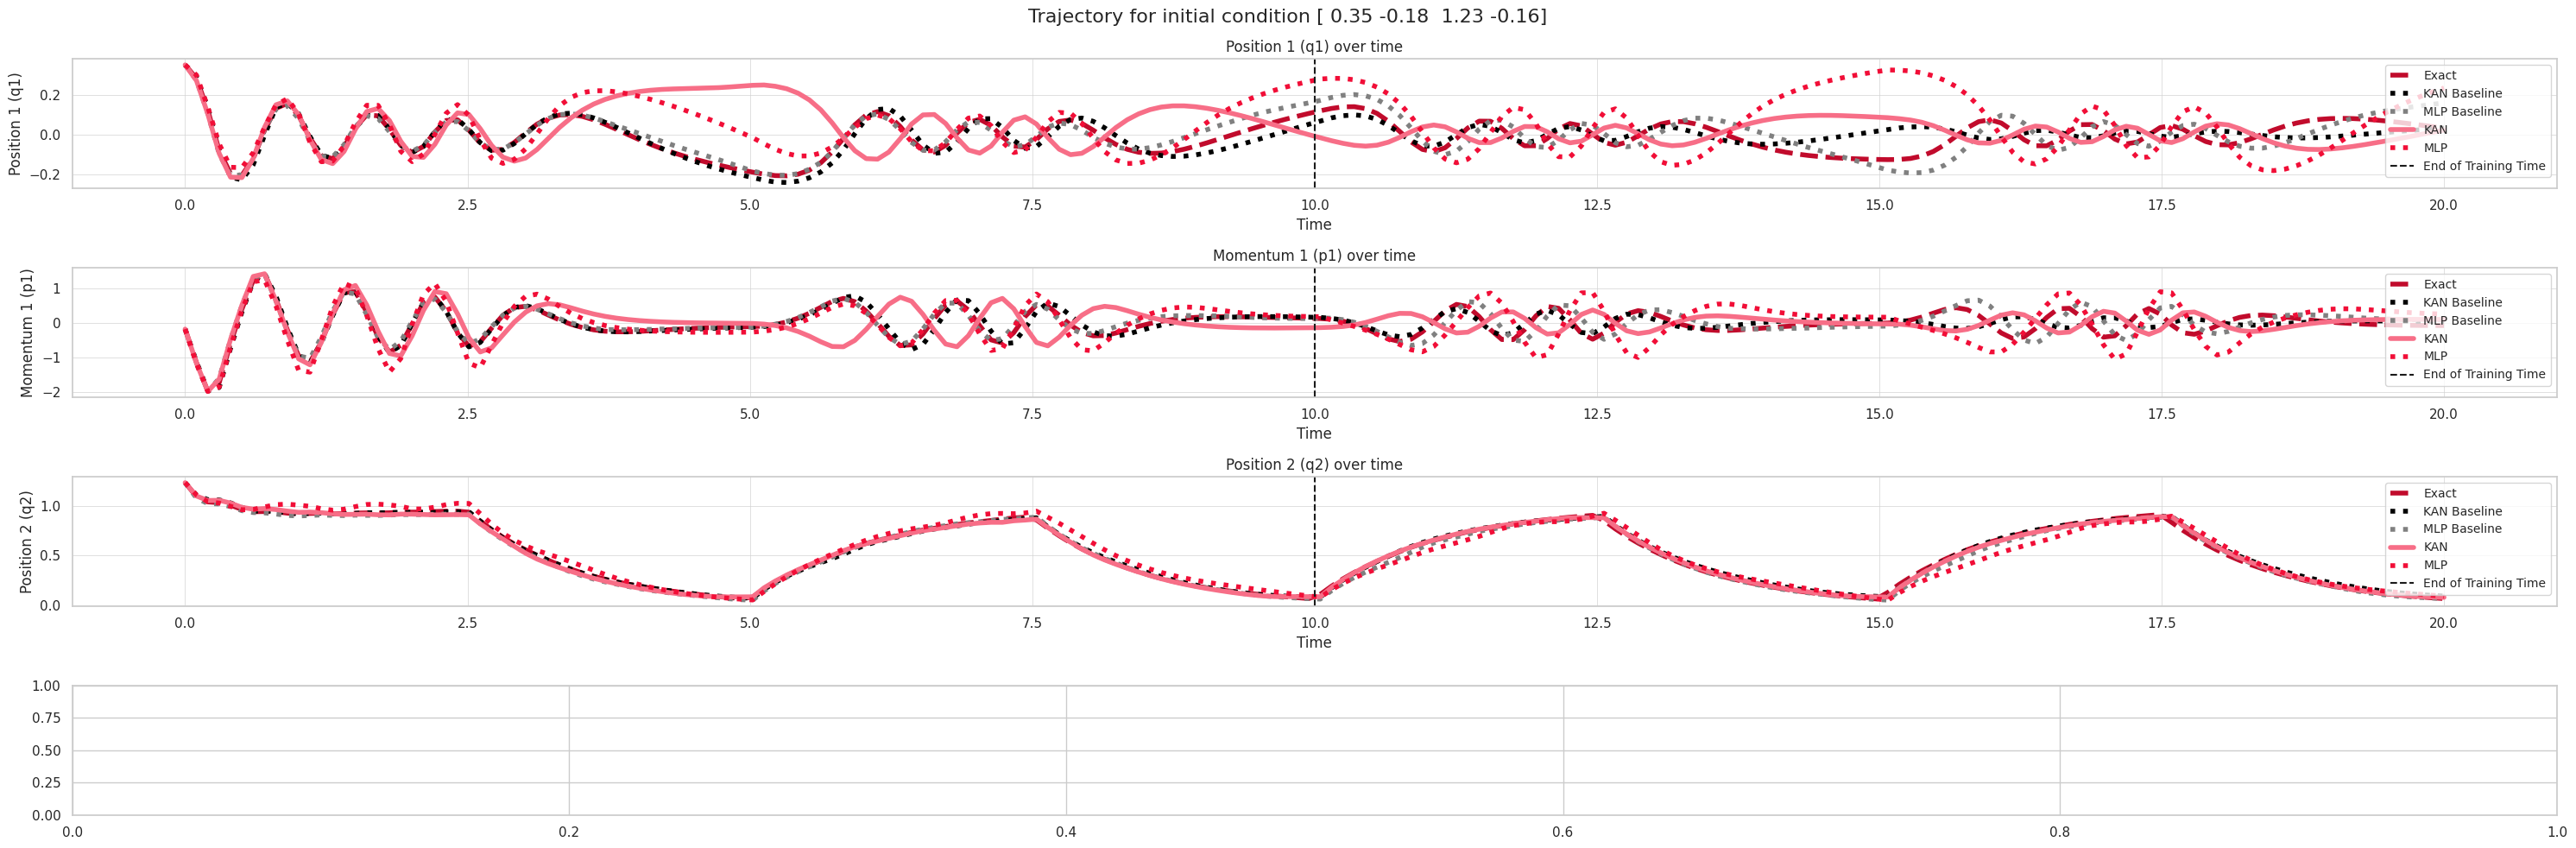

100%|██████████| 199/199 [00:22<00:00,  8.78it/s]


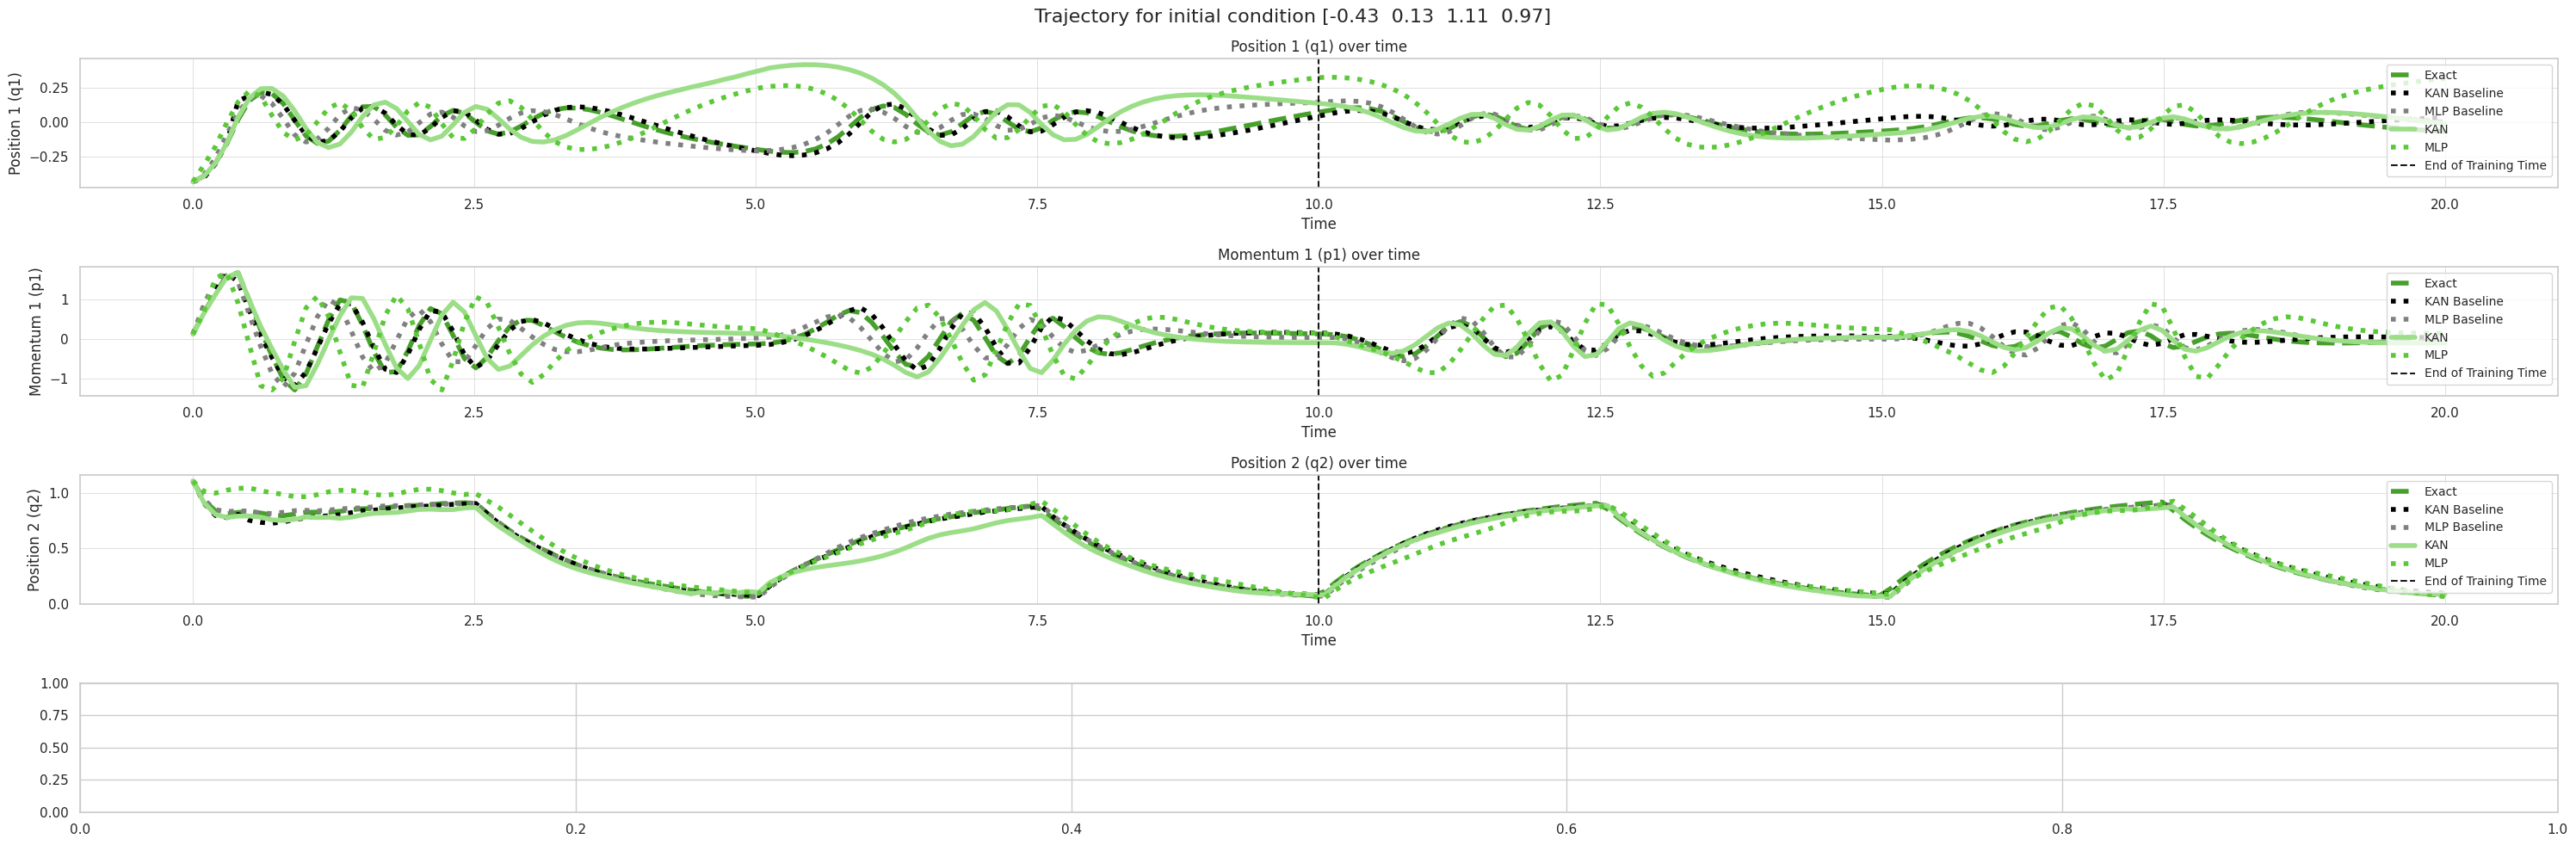

100%|██████████| 199/199 [00:23<00:00,  8.33it/s]


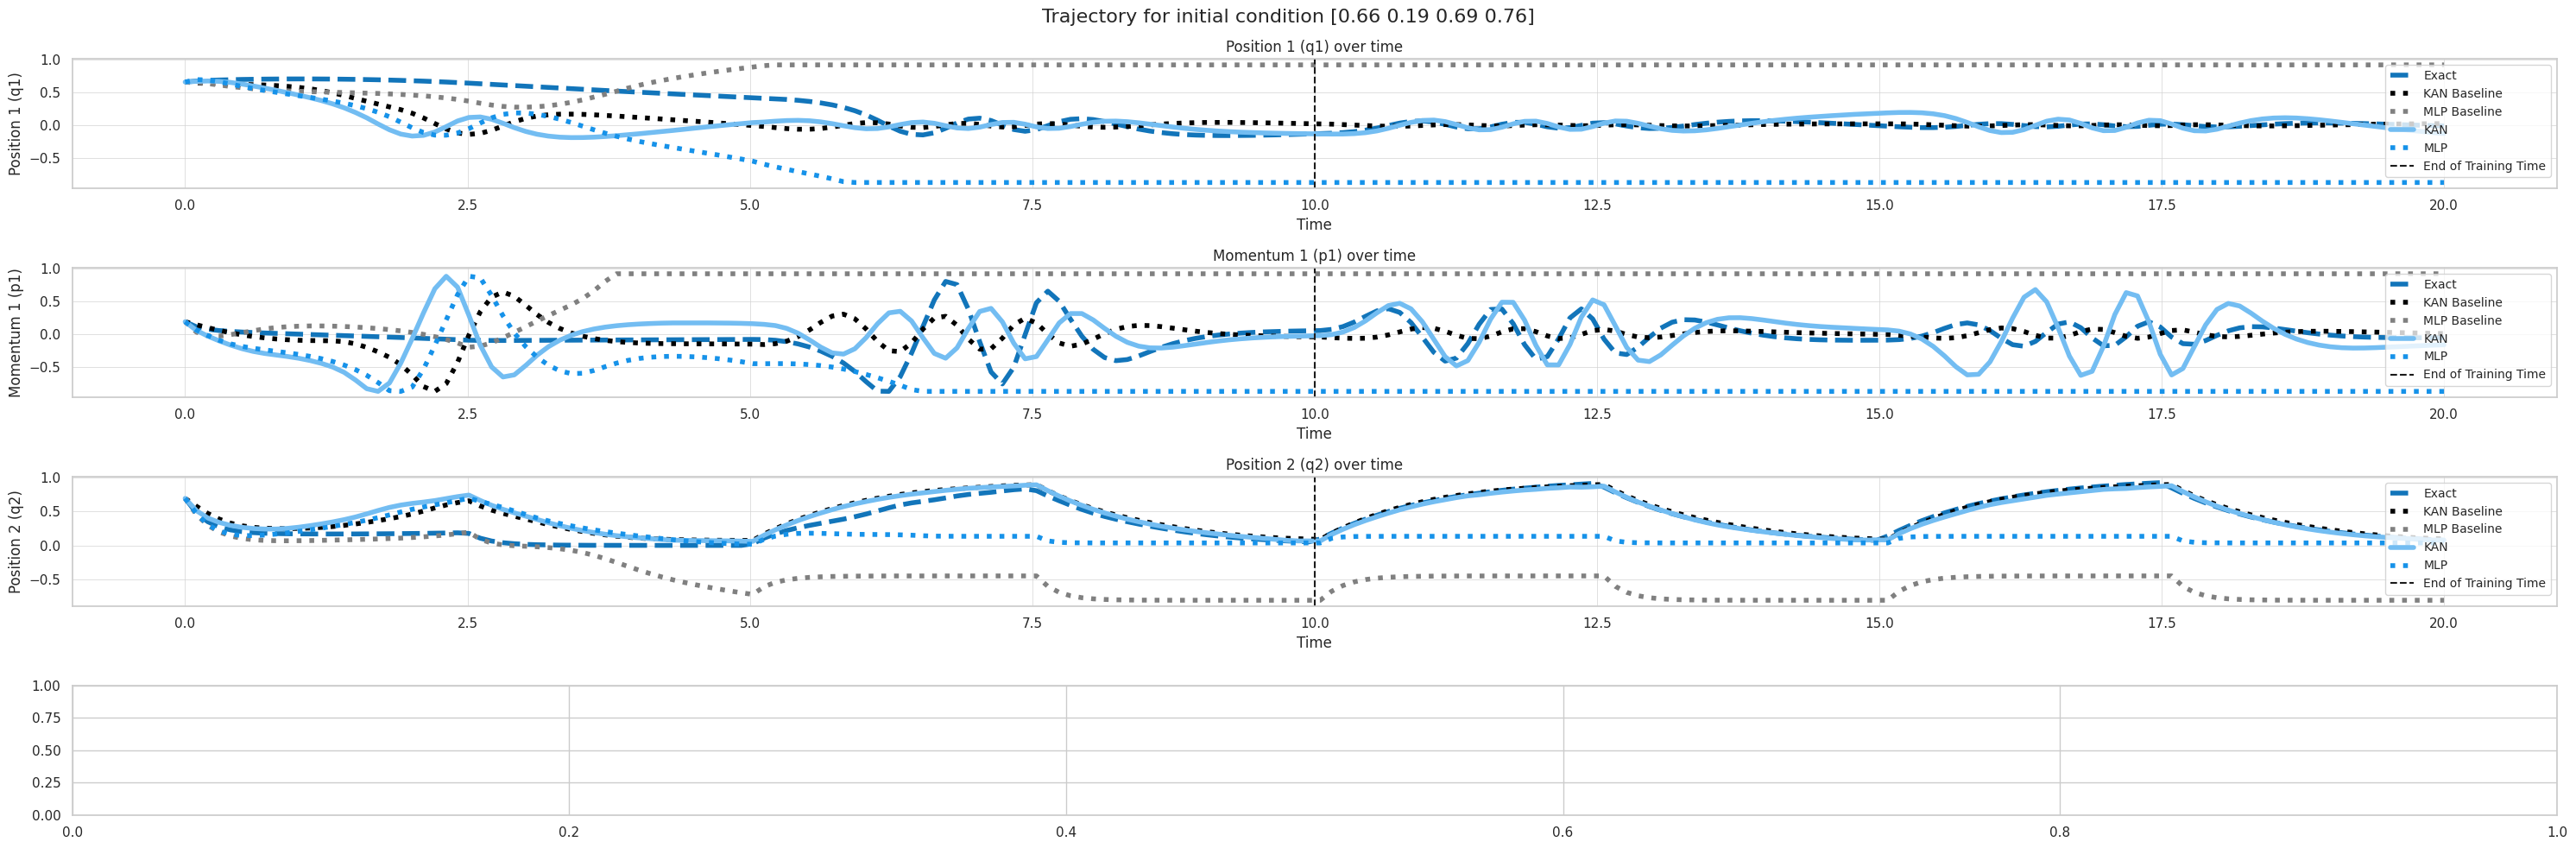

In [8]:
from tqdm import tqdm
sns.set_theme(style="whitegrid")

tmax = 20.0
t_vis = np.linspace(0, tmax, 200)

num_trajectories = 3
initial_states_vis = np.array([[np.random.uniform(low, high) for low, high in initial_state_ranges] + [np.random.uniform(-1, 1)] for _ in range(num_trajectories)])
initial_states_vis = np.round(initial_states_vis, 2)

palette = sns.color_palette("husl", num_trajectories)
colors_exact = [sns.set_hls_values(palette[i], l=0.4) for i in range(num_trajectories)]
colors_kan = [sns.set_hls_values(palette[i], l=0.7) for i in range(num_trajectories)]
colors_mlp = [sns.set_hls_values(palette[i], l=0.5) for i in range(num_trajectories)]
def plot_trajectory(init_state, t_axis, color_exact, color_kan, color_mlp):
    solution_vis = odeint(system_dynamics, init_state[:3], t_axis)

    input_u = np.array([generate_input_u(t) for t in t_axis])
    input_u = input_u.reshape(-1, 1)


    #predictions_mlp = model_mlp.predict(X_test)
    #predictions_kan = model_kan.predict(X_test)
    
    predicted_trajectory_baseline_mlp = np.zeros_like(solution_vis)
    predicted_trajectory_baseline_kan = np.zeros_like(solution_vis)
    predicted_trajectory_mlp = np.zeros_like(solution_vis)
    predicted_trajectory_kan = np.zeros_like(solution_vis)
    
    predicted_trajectory_baseline_mlp[0] = solution_vis[0]
    predicted_trajectory_baseline_kan[0] = solution_vis[0]
    predicted_trajectory_mlp[0] = solution_vis[0]
    predicted_trajectory_kan[0] = solution_vis[0]
    m, M = np.min(solution_vis), np.max(solution_vis)
    for j in tqdm(range(1, len(solution_vis))):
        predicted_trajectory_baseline_mlp[j] = predicted_trajectory_baseline_mlp[j-1] + model_mlp_baseline.predict(np.concatenate([predicted_trajectory_baseline_mlp[j-1: j], input_u[j-1: j]], axis=1), verbose=0)
        predicted_trajectory_baseline_mlp = np.clip(predicted_trajectory_baseline_mlp, m, M)
        predicted_trajectory_baseline_kan[j] = predicted_trajectory_baseline_kan[j-1] + model_kan_baseline.predict(np.concatenate([predicted_trajectory_baseline_kan[j-1: j], input_u[j-1: j]], axis=1), verbose=0)
        predicted_trajectory_baseline_kan = np.clip(predicted_trajectory_baseline_kan, m, M)
        predicted_trajectory_mlp[j] = predicted_trajectory_mlp[j-1] + model_mlp.predict(np.concatenate([predicted_trajectory_mlp[j-1: j], input_u[j-1: j]], axis=1), verbose=0)
        predicted_trajectory_mlp = np.clip(predicted_trajectory_mlp, m, M)
        predicted_trajectory_kan[j] = predicted_trajectory_kan[j-1] + model_kan.predict(np.concatenate([predicted_trajectory_kan[j-1: j], input_u[j-1: j]], axis=1), verbose=0)
        predicted_trajectory_kan = np.clip(predicted_trajectory_kan, m, M)

    fig, axs = plt.subplots(4, 1, figsize=(30, 10))
    fig.suptitle(f'Trajectory for initial condition {init_state}', fontsize=16)

    variables = ['Position 1 (q1)', 'Momentum 1 (p1)', 'Position 2 (q2)', 'Momentum 2 (p2)']
    
    for i in range(3):
        axs[i].plot(t_axis, solution_vis[:, i], linestyle="dashed", color=color_exact, label="Exact", linewidth=4)
        axs[i].plot(t_axis, predicted_trajectory_baseline_kan[:, i], linestyle="dotted", color='black', label="KAN Baseline", linewidth=4)
        axs[i].plot(t_axis, predicted_trajectory_baseline_mlp[:, i], linestyle="dotted", color='grey', label="MLP Baseline", linewidth=4)
        axs[i].plot(t_axis, predicted_trajectory_kan[:, i], color=color_kan, label="KAN", linewidth=4)
        axs[i].plot(t_axis, predicted_trajectory_mlp[:, i], linestyle="dotted", color=color_mlp, label="MLP", linewidth=4)
        axs[i].axvline(x=10, color='k', linestyle='--', label='End of Training Time')
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel(variables[i])
        axs[i].legend(loc='upper right', fontsize='small')
        axs[i].set_title(f'{variables[i]} over time')
        axs[i].grid(color='lightgrey', linestyle='-', linewidth=0.5)

    plt.tight_layout()
    plt.show()

for i, init_state in enumerate(initial_states_vis):
    plot_trajectory(init_state, t_vis, colors_exact[i], colors_kan[i], colors_mlp[i])

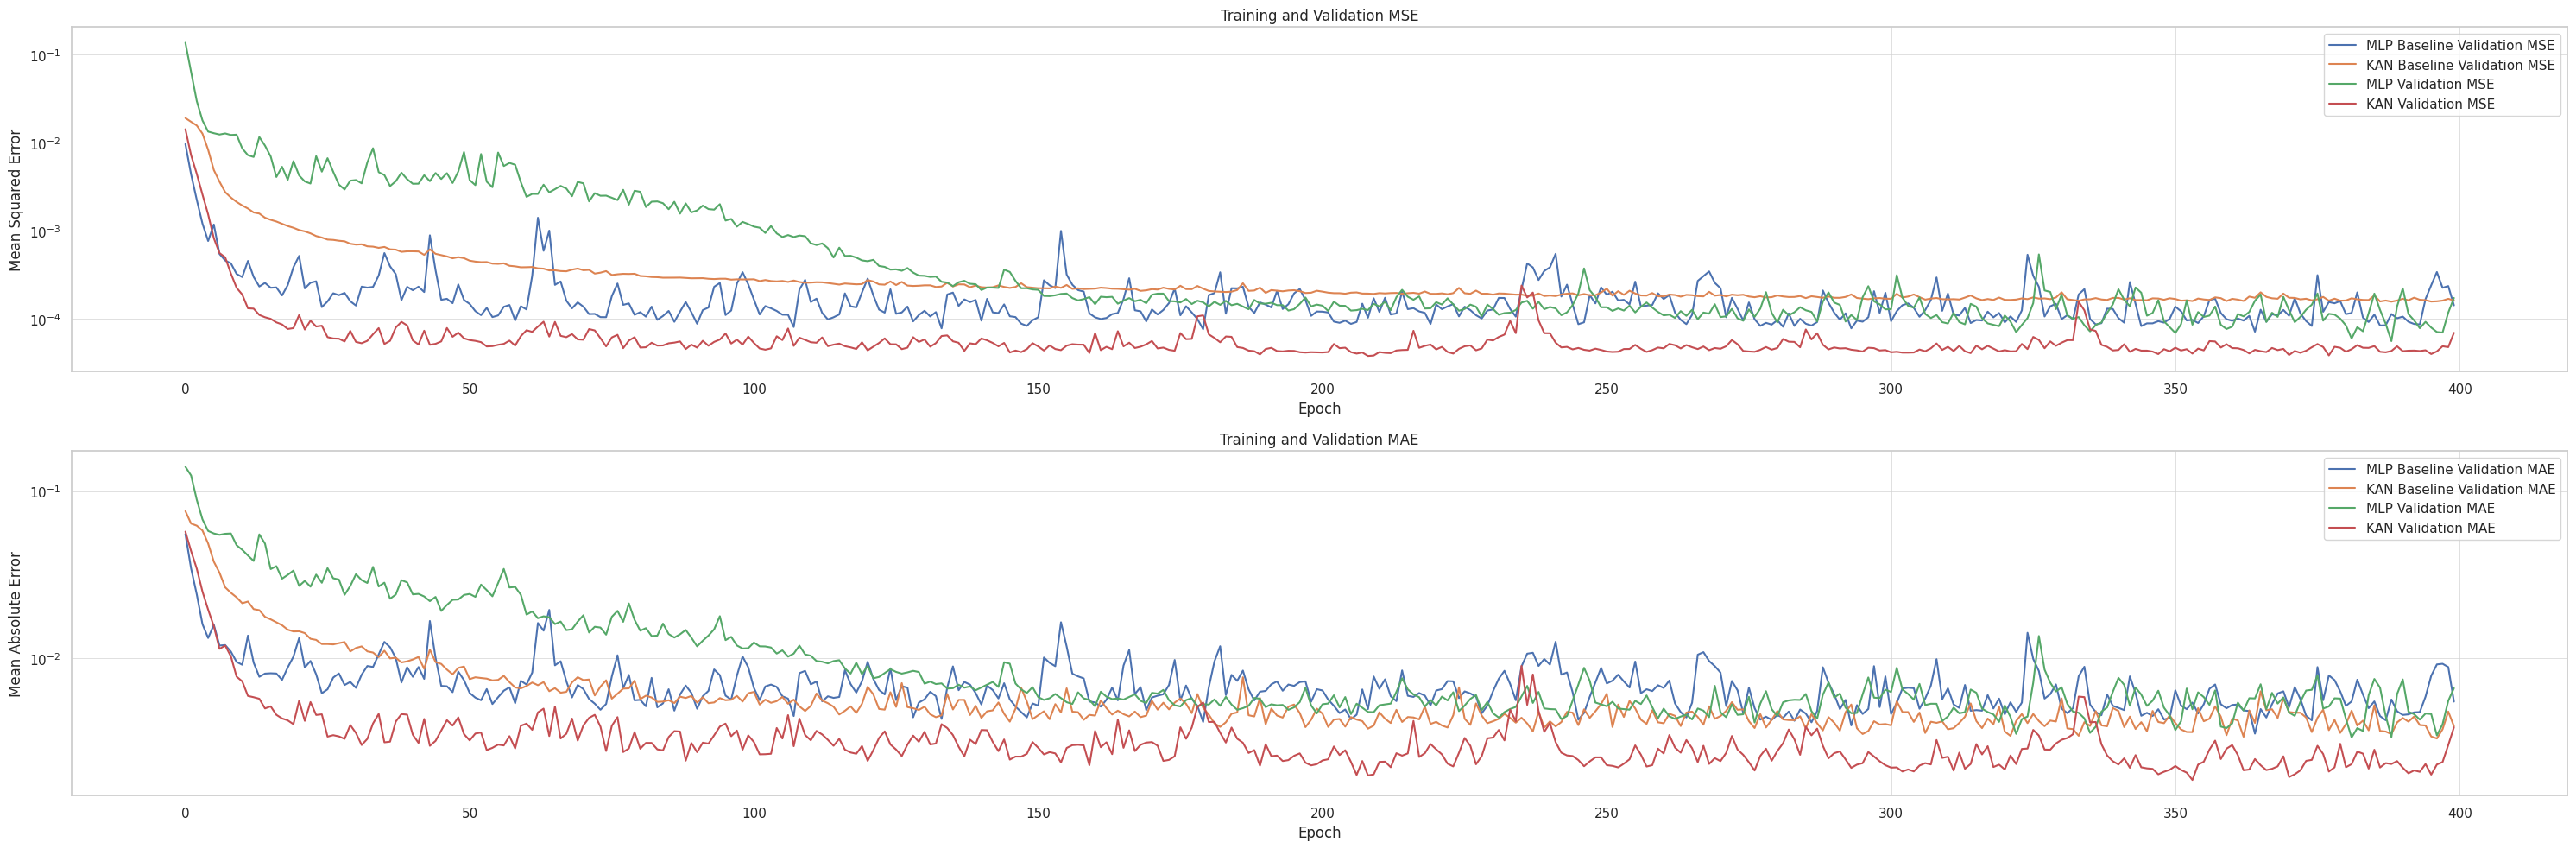

In [9]:
plt.figure(figsize=(30, 10))

plt.subplot(2, 1, 1)
plt.plot(history_mlp_baseline.history['val_loss'], label='MLP Baseline Validation MSE')
plt.plot(history_kan_baseline.history['val_loss'], label='KAN Baseline Validation MSE')
plt.plot(history_mlp.history['val_loss'], label='MLP Validation MSE')
plt.plot(history_kan.history['val_loss'], label='KAN Validation MSE')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)

plt.subplot(2, 1, 2)
plt.plot(history_mlp_baseline.history['val_mae'], label='MLP Baseline Validation MAE')
plt.plot(history_kan_baseline.history['val_mae'], label='KAN Baseline Validation MAE')
plt.plot(history_mlp.history['val_mae'], label='MLP Validation MAE')
plt.plot(history_kan.history['val_mae'], label='KAN Validation MAE')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

## Second Training : The second training was performed using **90 trajectories** in the dataset.


In [ ]:
# Constants
m = 1  # mass of the ball
R = 0.1  # electric resistance
c = 1  # drag coefficient

# Définition de l'inductance
def L(x1):
    return 1 / (0.1 + x1**2)


# Hamiltonien
def hamiltonian(x):
    return 0.5 * x[1]**2 / m + 0.5 * x[2]**2 / L(x[0])

# Gradient du Hamiltonien
def grad_hamiltonian(x):
    dH_dx1 = 0.5 * x[2]**2 * (2 * x[0]) / (0.1 + x[0]**2)**2
    dH_dx2 = x[1] / m
    dH_dx3 = x[2] / L(x[0])
    return np.array([dH_dx1, dH_dx2, dH_dx3])

# Définition de la matrice J-R
def J_R(x):
    return np.array([[0, 1, 0],
                     [-1, -c * np.abs(x[1]), 0],
                     [0, 0, -1 / R]])

G = np.array([0, 0, 1])

def generate_input_u(t):
    period = 5.0
    amplitude = 1
    return amplitude if (t % period) < (period / 2) else 0

def system_dynamics(x, t):
    grad_H = grad_hamiltonian(x)
    u = generate_input_u(t)
    return J_R(x) @ grad_H + G * u


simulation_time = 10.0
num_steps = 100
num_trajectories = 90

initial_state_ranges = [(-0.75, 0.75), (-0.2, 0.2), (0.3, 1.3)]

def generate_trajectory(initial_state):
    t = np.linspace(0, simulation_time, num_steps)
    return odeint(system_dynamics, initial_state, t)

def get_data():

    all_X = []
    all_y = []
    all_u = []
    
    for _ in range(num_trajectories):
        initial_state = np.array([np.round(np.random.uniform(low, high), 2) for low, high in initial_state_ranges])
        trajectory = generate_trajectory(initial_state)
        t = np.linspace(0, simulation_time, num_steps)
        input_u = np.array([generate_input_u(ti) for ti in t[:-1]])
        X = np.hstack((trajectory[:-1], input_u.reshape(-1, 1)))
        y = trajectory[1:] - trajectory[:-1]
        all_X.append(X)
        all_y.append(y)
    
    X = np.concatenate(all_X)
    y = np.concatenate(all_y)
    
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
    y_tf = tf.convert_to_tensor(y, dtype=tf.float32)
    
    return X_tf, y_tf

X_tf, y_tf = get_data()
X_val_tf, y_val_tf = get_data()

class HamiltonianNN_MLP(tf.keras.Model):
    def __init__(self, n=3, num_subdomains=3):
        super(HamiltonianNN_MLP, self).__init__()
        self.n = n
        self.num_subdomains = num_subdomains
        
        self.subdomain_networks = []
        for _ in range(num_subdomains):
            subdomain_net = {
                'Q': self.create_network(n * (n + 1) // 2),
                'W': self.create_network(n * (n + 1) // 2),
                'J': self.create_network(n * (n - 1) // 2),
                'G': self.create_network(n)
            }
            self.subdomain_networks.append(subdomain_net)

    def create_network(self, output_dim):
        return tf.keras.Sequential([
            tf.keras.layers.Dense(100, activation='tanh', input_shape=(self.n,)),
            tf.keras.layers.Dense(100, activation='tanh'),
            tf.keras.layers.Dense(output_dim)
        ])
    
    def window_function(self, x, subdomain):
        centers = tf.linspace(-1.0, 1.0, self.num_subdomains)
        dist = tf.reduce_sum(tf.square(x - centers[subdomain]), axis=-1)
        scale = 1.0 / (0.1 + tf.exp(-dist))  # Ajustement de l'échelle
        return tf.exp(-dist / (2.0 * scale))
    
    def vtu(self, v):
        n = self.n
        batch_size = tf.shape(v)[0]
        V = tf.zeros((batch_size, n, n), dtype=tf.float32)
        idx = tf.repeat(tf.expand_dims(tf.constant([[i, j] for i in range(n) for j in range(i, n)]), 0), batch_size, axis=0)
        batch_idx = tf.repeat(tf.expand_dims(tf.range(batch_size), 1), idx.shape[1], axis=1)
        idx = tf.stack([batch_idx, idx[:,:,0], idx[:,:,1]], axis=-1)
        V = tf.tensor_scatter_nd_update(V, idx, v)
        return V
    
    def vtsu(self, v):
        n = self.n
        batch_size = tf.shape(v)[0]
        V = tf.zeros((batch_size, n, n), dtype=tf.float32)
        idx = tf.repeat(tf.expand_dims(tf.constant([[i, j] for i in range(n) for j in range(i+1, n)]), 0), batch_size, axis=0)
        batch_idx = tf.repeat(tf.expand_dims(tf.range(batch_size), 1), idx.shape[1], axis=1)
        idx = tf.stack([batch_idx, idx[:,:,0], idx[:,:,1]], axis=-1)
        V = tf.tensor_scatter_nd_update(V, idx, v)
        return V
    
    def grad_hamiltonian(self, x, Q):
        return tf.matmul(Q, x[:, :, tf.newaxis])[:, :, 0]

    def call(self, x):
        batch_size = tf.shape(x)[0]
        outputs = []
        weights = []

        x_state = x[:, :self.n] 
        u = x[:, self.n:] 
    
        for i, subdomain_net in enumerate(self.subdomain_networks):
            window = self.window_function(x_state, i)  
        
            theta_Q = subdomain_net['Q'](x_state)
            theta_W = subdomain_net['W'](x_state)
            theta_J = subdomain_net['J'](x_state)
            theta_G = subdomain_net['G'](x_state)
        
            Q = tf.matmul(self.vtu(theta_Q), tf.transpose(self.vtu(theta_Q), perm=[0, 2, 1]))
            W = tf.matmul(self.vtu(theta_W), tf.transpose(self.vtu(theta_W), perm=[0, 2, 1]))
            J_pred = tf.matmul(self.vtsu(theta_J), tf.transpose(self.vtsu(theta_J), perm=[0, 2, 1])) - \
                    tf.matmul(tf.transpose(self.vtsu(theta_J), perm=[0, 2, 1]), self.vtsu(theta_J))
        
            I = tf.eye(self.n, batch_shape=[batch_size])
            R_pred = tf.matmul(tf.matmul(I, W), I)
            G_pred = tf.reshape(theta_G, (batch_size, self.n, 1))
        
            grad_H = self.grad_hamiltonian(x_state, Q) 
            output = tf.matmul(J_pred - R_pred, grad_H[:, :, tf.newaxis])[:, :, 0] + tf.matmul(G_pred, u[:, :, tf.newaxis])[:, :, 0]
            outputs.append(window[:, tf.newaxis] * output)
            weights.append(window[:, tf.newaxis])

        outputs_sum = tf.add_n(outputs)
        weights_sum = tf.add_n(weights)
        final_output = outputs_sum / (weights_sum + 1e-20)  
        return final_output

class HamiltonianNN_KAN(tf.keras.Model):
    def __init__(self, n=3, num_subdomains=3):
        super(HamiltonianNN_KAN, self).__init__()
        self.n = n
        self.num_subdomains = num_subdomains
        
        self.subdomain_networks = []
        for _ in range(num_subdomains):
            subdomain_net = {
                'Q': self.create_network(n * (n + 1) // 2),
                'W': self.create_network(n * (n + 1) // 2),
                'J': self.create_network(n * (n - 1) // 2),
                'G': self.create_network(n)
            }
            self.subdomain_networks.append(subdomain_net)
    
    def create_network(self, output_dim):
        return tf.keras.Sequential([
            DenseKAN(4, input_shape=(self.n,)),
            DenseKAN(4),
            DenseKAN(4),
            DenseKAN(4),
            DenseKAN(output_dim)
        ])
    
    def window_function(self, x, subdomain):
        centers = tf.linspace(-1.0, 1.0, self.num_subdomains)
        dist = tf.reduce_sum(tf.square(x - centers[subdomain]), axis=-1)
        scale = 1.0 / (0.1 + tf.exp(-dist))
        return tf.exp(-dist / (2.0 * scale))
    
    def vtu(self, v):
        n = self.n
        batch_size = tf.shape(v)[0]
        V = tf.zeros((batch_size, n, n), dtype=tf.float32)
        idx = tf.repeat(tf.expand_dims(tf.constant([[i, j] for i in range(n) for j in range(i, n)]), 0), batch_size, axis=0)
        batch_idx = tf.repeat(tf.expand_dims(tf.range(batch_size), 1), idx.shape[1], axis=1)
        idx = tf.stack([batch_idx, idx[:,:,0], idx[:,:,1]], axis=-1)
        V = tf.tensor_scatter_nd_update(V, idx, v)
        return V
    
    def vtsu(self, v):
        n = self.n
        batch_size = tf.shape(v)[0]
        V = tf.zeros((batch_size, n, n), dtype=tf.float32)
        idx = tf.repeat(tf.expand_dims(tf.constant([[i, j] for i in range(n) for j in range(i+1, n)]), 0), batch_size, axis=0)
        batch_idx = tf.repeat(tf.expand_dims(tf.range(batch_size), 1), idx.shape[1], axis=1)
        idx = tf.stack([batch_idx, idx[:,:,0], idx[:,:,1]], axis=-1)
        V = tf.tensor_scatter_nd_update(V, idx, v)
        return V
    
    def grad_hamiltonian(self, x, Q):
        return tf.matmul(Q, x[:, :, tf.newaxis])[:, :, 0]
    
    def call(self, x):
        batch_size = tf.shape(x)[0]
        outputs = []
        weights = []

        x_state = x[:, :self.n] 
        u = x[:, self.n:] 
    
        for i, subdomain_net in enumerate(self.subdomain_networks):
            window = self.window_function(x_state, i)  
        
            theta_Q = subdomain_net['Q'](x_state)
            theta_W = subdomain_net['W'](x_state)
            theta_J = subdomain_net['J'](x_state)
            theta_G = subdomain_net['G'](x_state)
        
            Q = tf.matmul(self.vtu(theta_Q), tf.transpose(self.vtu(theta_Q), perm=[0, 2, 1]))
            W = tf.matmul(self.vtu(theta_W), tf.transpose(self.vtu(theta_W), perm=[0, 2, 1]))
            J_pred = tf.matmul(self.vtsu(theta_J), tf.transpose(self.vtsu(theta_J), perm=[0, 2, 1])) - \
                    tf.matmul(tf.transpose(self.vtsu(theta_J), perm=[0, 2, 1]), self.vtsu(theta_J))
        
            I = tf.eye(self.n, batch_shape=[batch_size])
            R_pred = tf.matmul(tf.matmul(I, W), I)
            G_pred = tf.reshape(theta_G, (batch_size, self.n, 1))
        
            grad_H = self.grad_hamiltonian(x_state, Q) 
            output = tf.matmul(J_pred - R_pred, grad_H[:, :, tf.newaxis])[:, :, 0] + tf.matmul(G_pred, u[:, :, tf.newaxis])[:, :, 0]
            outputs.append(window[:, tf.newaxis] * output)
            weights.append(window[:, tf.newaxis])

        outputs_sum = tf.add_n(outputs)
        weights_sum = tf.add_n(weights)
        final_output = outputs_sum / (weights_sum + 1e-20)  
        return final_output

model_mlp_baseline = tf.keras.Sequential([
            tf.keras.layers.Dense(100, activation='tanh', input_shape=(4,)),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.Dense(3)
        ])
model_kan_baseline = tf.keras.Sequential([
            DenseKAN(4, input_shape=(4,)),
            DenseKAN(4),
            DenseKAN(3)
        ])
model_mlp = HamiltonianNN_MLP()
model_kan = HamiltonianNN_KAN()

# Define training parameters
batch_size = 128
epochs = 200
lr=.005

# Calculate the number of steps per epoch and total steps
steps_per_epoch = math.ceil(len(X_tf) / batch_size)
total_steps = steps_per_epoch * epochs

# Create a cosine decay learning rate schedule
lr_schedule = CosineDecay(
    initial_learning_rate=lr,
    decay_steps=total_steps,
    alpha=0.01  # Final learning rate will be alpha * initial_learning_rate
)

use_scheduler = False

# Optimizers for both models using the cosine decay learning rate schedule
optimizer_mlp_baseline = legacy_optimizers.Adam(learning_rate=lr_schedule if use_scheduler else lr)
optimizer_kan_baseline = legacy_optimizers.Adam(learning_rate=lr_schedule if use_scheduler else lr)
optimizer_mlp = legacy_optimizers.Adam(learning_rate=lr_schedule if use_scheduler else lr)
optimizer_kan = legacy_optimizers.Adam(learning_rate=lr_schedule if use_scheduler else lr)

# Compile models with MSE loss and MAE as an additional metric
model_mlp_baseline.compile(optimizer=optimizer_mlp_baseline, loss='mse', metrics=['mae'])
model_kan_baseline.compile(optimizer=optimizer_kan_baseline, loss='mse', metrics=['mae'])
model_mlp.compile(optimizer=optimizer_mlp, loss='mse', metrics=['mae'])
model_kan.compile(optimizer=optimizer_kan, loss='mse', metrics=['mae'])

# Build the models with a dummy input
dummy_input = tf.random.normal((1, 4))
_ = model_mlp_baseline(dummy_input)
_ = model_kan_baseline(dummy_input)
_ = model_mlp(dummy_input)
_ = model_kan(dummy_input)

# Train all models with the cosine decay learning rate schedule
validation_data = (X_val_tf, y_val_tf)
history_mlp_baseline = model_mlp_baseline.fit(
    X_tf, y_tf,
    validation_data=validation_data,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)
history_kan_baseline = model_kan_baseline.fit(
    X_tf, y_tf,
    validation_data=validation_data,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)
history_kan = model_kan.fit(
    X_tf, y_tf,
    validation_data=validation_data,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)
history_mlp = model_mlp.fit(
    X_tf, y_tf,
    validation_data=validation_data,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)

100%|██████████| 199/199 [00:28<00:00,  6.93it/s]


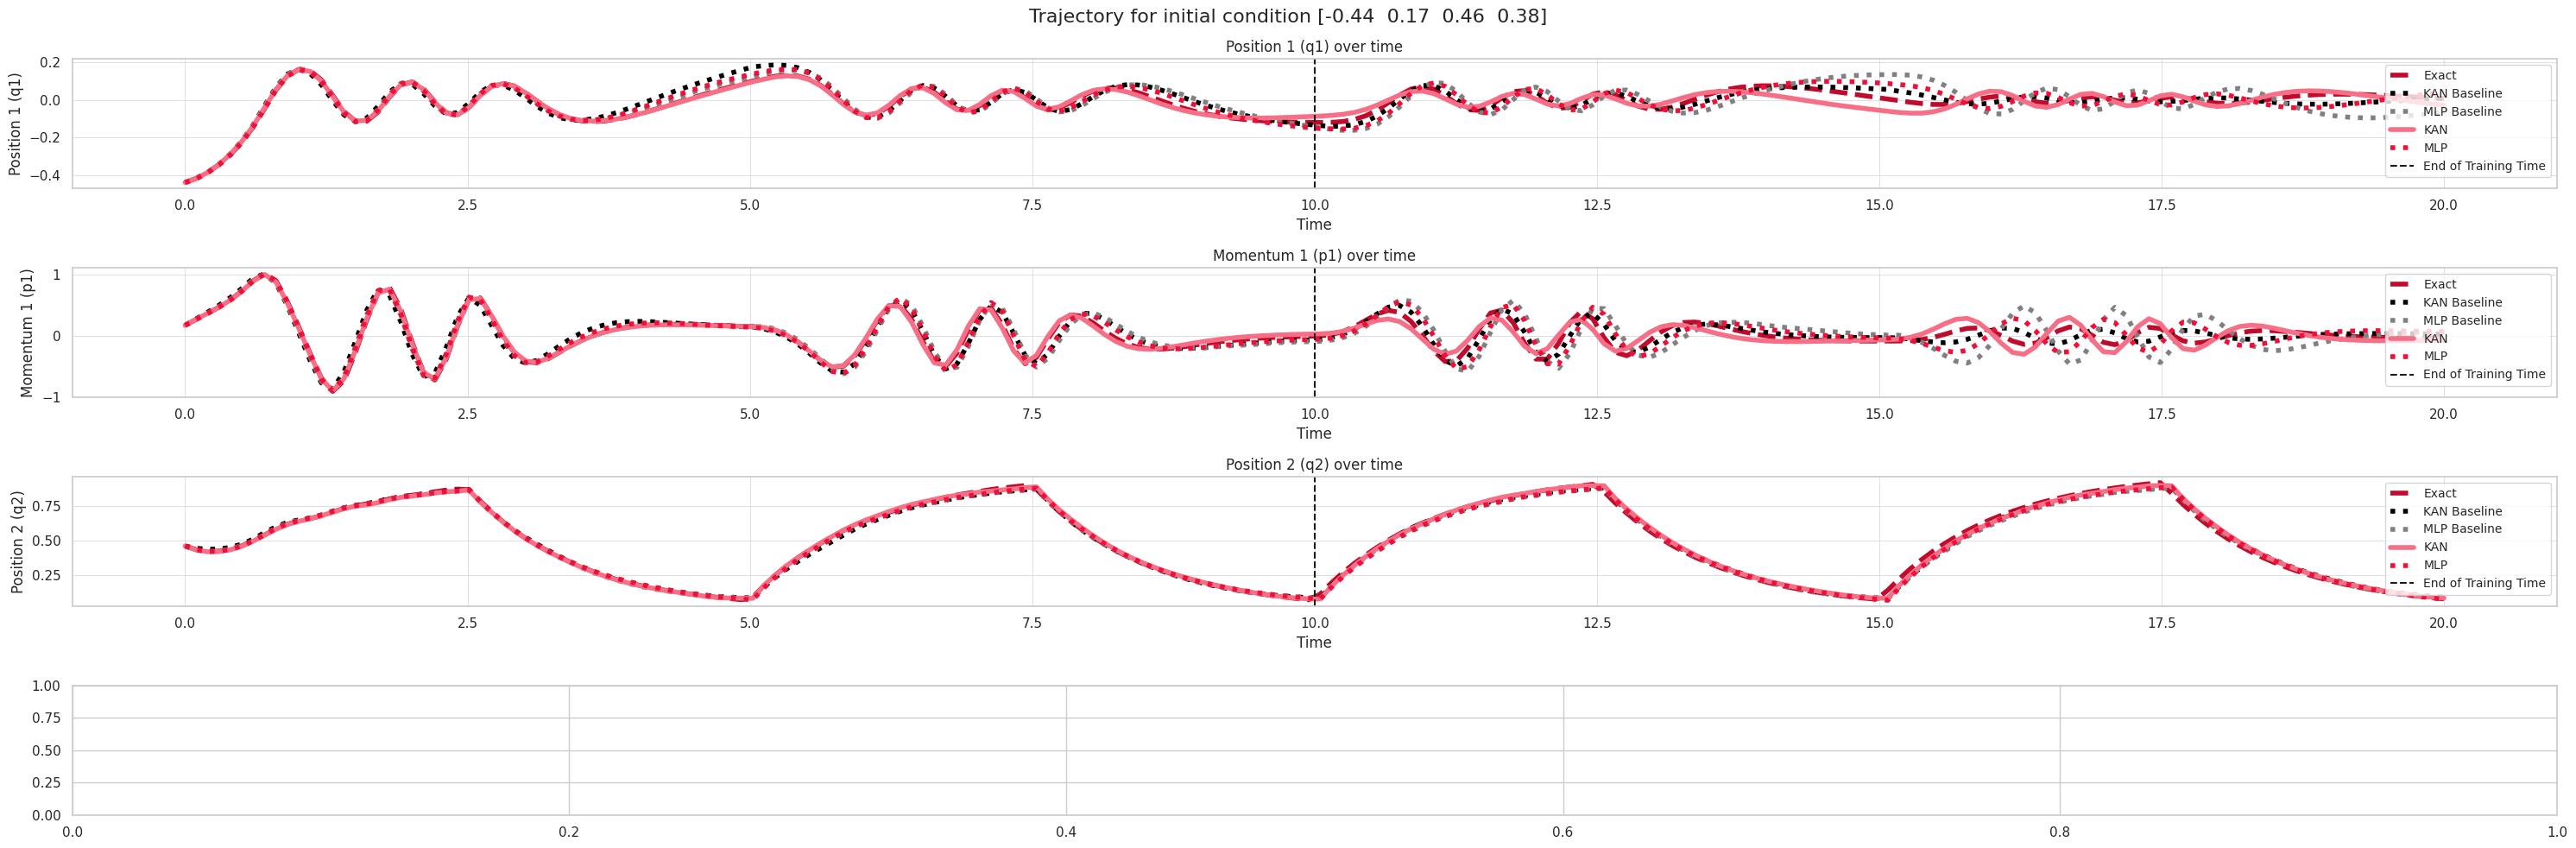

100%|██████████| 199/199 [00:21<00:00,  9.32it/s]


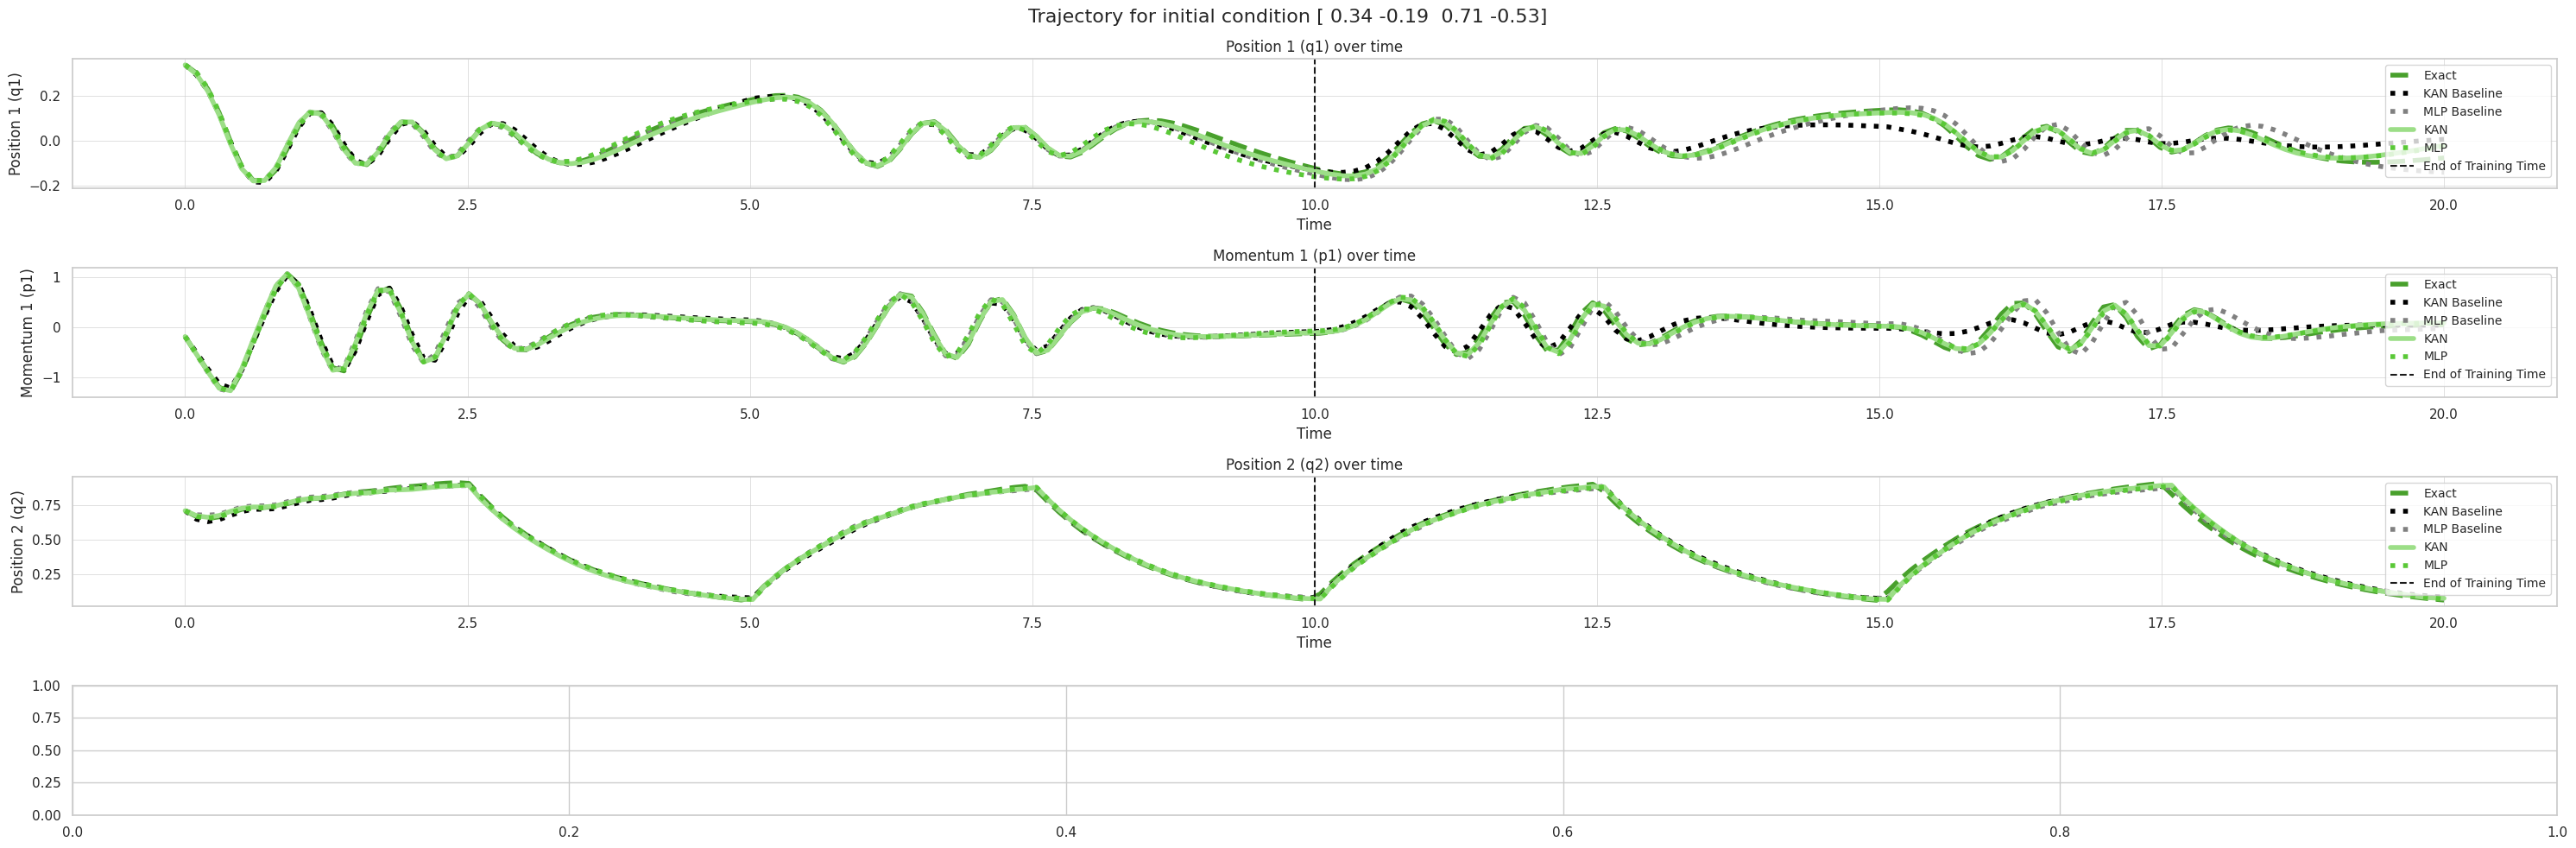

100%|██████████| 199/199 [00:21<00:00,  9.37it/s]


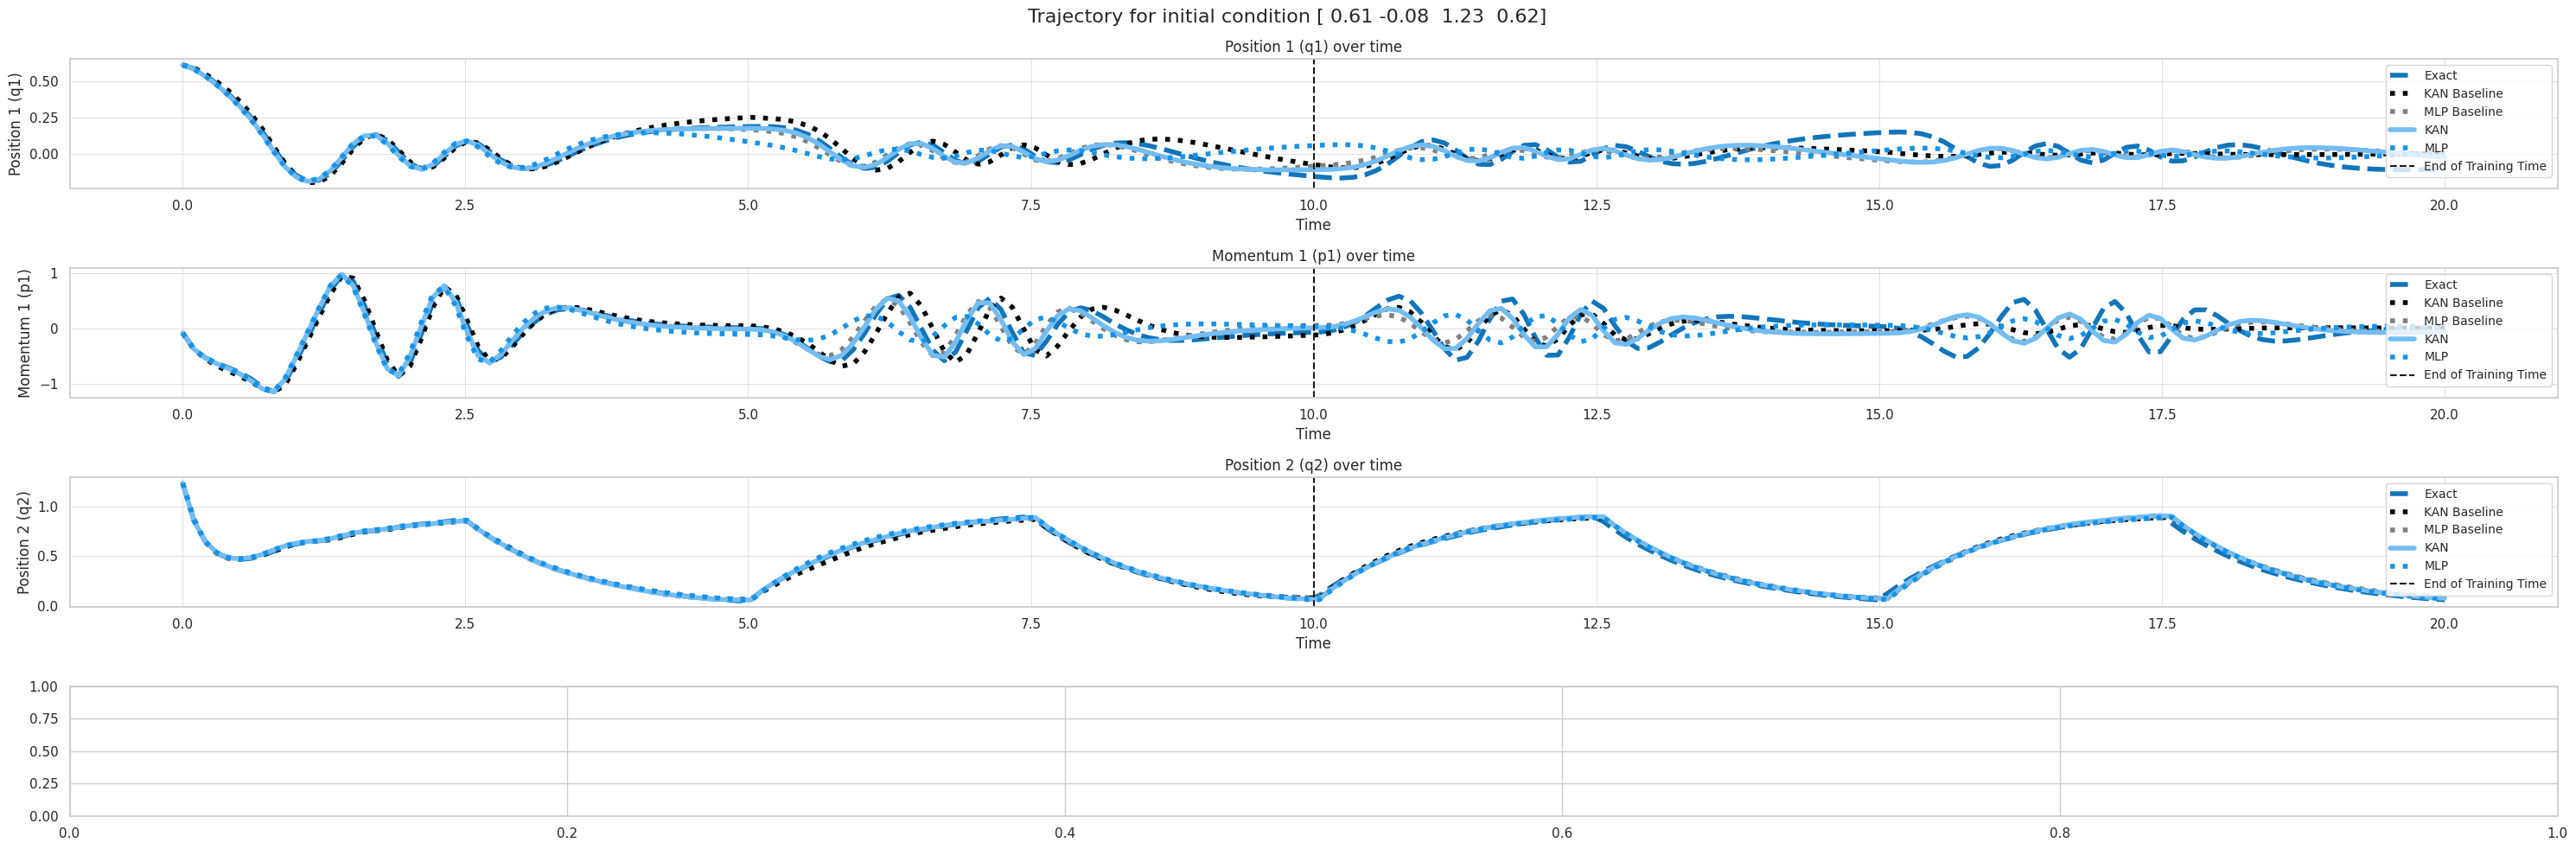

In [22]:
from tqdm import tqdm
sns.set_theme(style="whitegrid")

tmax = 20.0
t_vis = np.linspace(0, tmax, 500)

num_trajectories = 3
initial_states_vis = np.array([[np.random.uniform(low, high) for low, high in initial_state_ranges] + [np.random.uniform(-1, 1)] for _ in range(num_trajectories)])
initial_states_vis = np.round(initial_states_vis, 2)

palette = sns.color_palette("husl", num_trajectories)
colors_exact = [sns.set_hls_values(palette[i], l=0.4) for i in range(num_trajectories)]
colors_kan = [sns.set_hls_values(palette[i], l=0.7) for i in range(num_trajectories)]
colors_mlp = [sns.set_hls_values(palette[i], l=0.5) for i in range(num_trajectories)]
def plot_trajectory(init_state, t_axis, color_exact, color_kan, color_mlp):
    solution_vis = odeint(system_dynamics, init_state[:3], t_axis)

    input_u = np.array([generate_input_u(t) for t in t_axis])
    input_u = input_u.reshape(-1, 1)


    #predictions_mlp = model_mlp.predict(X_test)
    #predictions_kan = model_kan.predict(X_test)
    
    predicted_trajectory_baseline_mlp = np.zeros_like(solution_vis)
    predicted_trajectory_baseline_kan = np.zeros_like(solution_vis)
    predicted_trajectory_mlp = np.zeros_like(solution_vis)
    predicted_trajectory_kan = np.zeros_like(solution_vis)
    
    predicted_trajectory_baseline_mlp[0] = solution_vis[0]
    predicted_trajectory_baseline_kan[0] = solution_vis[0]
    predicted_trajectory_mlp[0] = solution_vis[0]
    predicted_trajectory_kan[0] = solution_vis[0]
    m, M = np.min(solution_vis), np.max(solution_vis)
    for j in tqdm(range(1, len(solution_vis))):
        predicted_trajectory_baseline_mlp[j] = predicted_trajectory_baseline_mlp[j-1] + model_mlp_baseline.predict(np.concatenate([predicted_trajectory_baseline_mlp[j-1: j], input_u[j-1: j]], axis=1), verbose=0)
        predicted_trajectory_baseline_mlp = np.clip(predicted_trajectory_baseline_mlp, m, M)
        predicted_trajectory_baseline_kan[j] = predicted_trajectory_baseline_kan[j-1] + model_kan_baseline.predict(np.concatenate([predicted_trajectory_baseline_kan[j-1: j], input_u[j-1: j]], axis=1), verbose=0)
        predicted_trajectory_baseline_kan = np.clip(predicted_trajectory_baseline_kan, m, M)
        predicted_trajectory_mlp[j] = predicted_trajectory_mlp[j-1] + model_mlp.predict(np.concatenate([predicted_trajectory_mlp[j-1: j], input_u[j-1: j]], axis=1), verbose=0)
        predicted_trajectory_mlp = np.clip(predicted_trajectory_mlp, m, M)
        predicted_trajectory_kan[j] = predicted_trajectory_kan[j-1] + model_kan.predict(np.concatenate([predicted_trajectory_kan[j-1: j], input_u[j-1: j]], axis=1), verbose=0)
        predicted_trajectory_kan = np.clip(predicted_trajectory_kan, m, M)

    fig, axs = plt.subplots(4, 1, figsize=(30, 10))
    fig.suptitle(f'Trajectory for initial condition {init_state}', fontsize=16)

    variables = ['Position 1 (q1)', 'Momentum 1 (p1)', 'Position 2 (q2)', 'Momentum 2 (p2)']
    
    for i in range(3):
        axs[i].plot(t_axis, solution_vis[:, i], linestyle="dashed", color=color_exact, label="Exact", linewidth=4)
        axs[i].plot(t_axis, predicted_trajectory_baseline_kan[:, i], linestyle="dotted", color='black', label="KAN Baseline", linewidth=4)
        axs[i].plot(t_axis, predicted_trajectory_baseline_mlp[:, i], linestyle="dotted", color='grey', label="MLP Baseline", linewidth=4)
        axs[i].plot(t_axis, predicted_trajectory_kan[:, i], color=color_kan, label="KAN", linewidth=4)
        axs[i].plot(t_axis, predicted_trajectory_mlp[:, i], linestyle="dotted", color=color_mlp, label="MLP", linewidth=4)
        axs[i].axvline(x=10, color='k', linestyle='--', label='End of Training Time')
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel(variables[i])
        axs[i].legend(loc='upper right', fontsize='small')
        axs[i].set_title(f'{variables[i]} over time')
        axs[i].grid(color='lightgrey', linestyle='-', linewidth=0.5)

    plt.tight_layout()
    plt.show()

for i, init_state in enumerate(initial_states_vis):
    plot_trajectory(init_state, t_vis, colors_exact[i], colors_kan[i], colors_mlp[i])

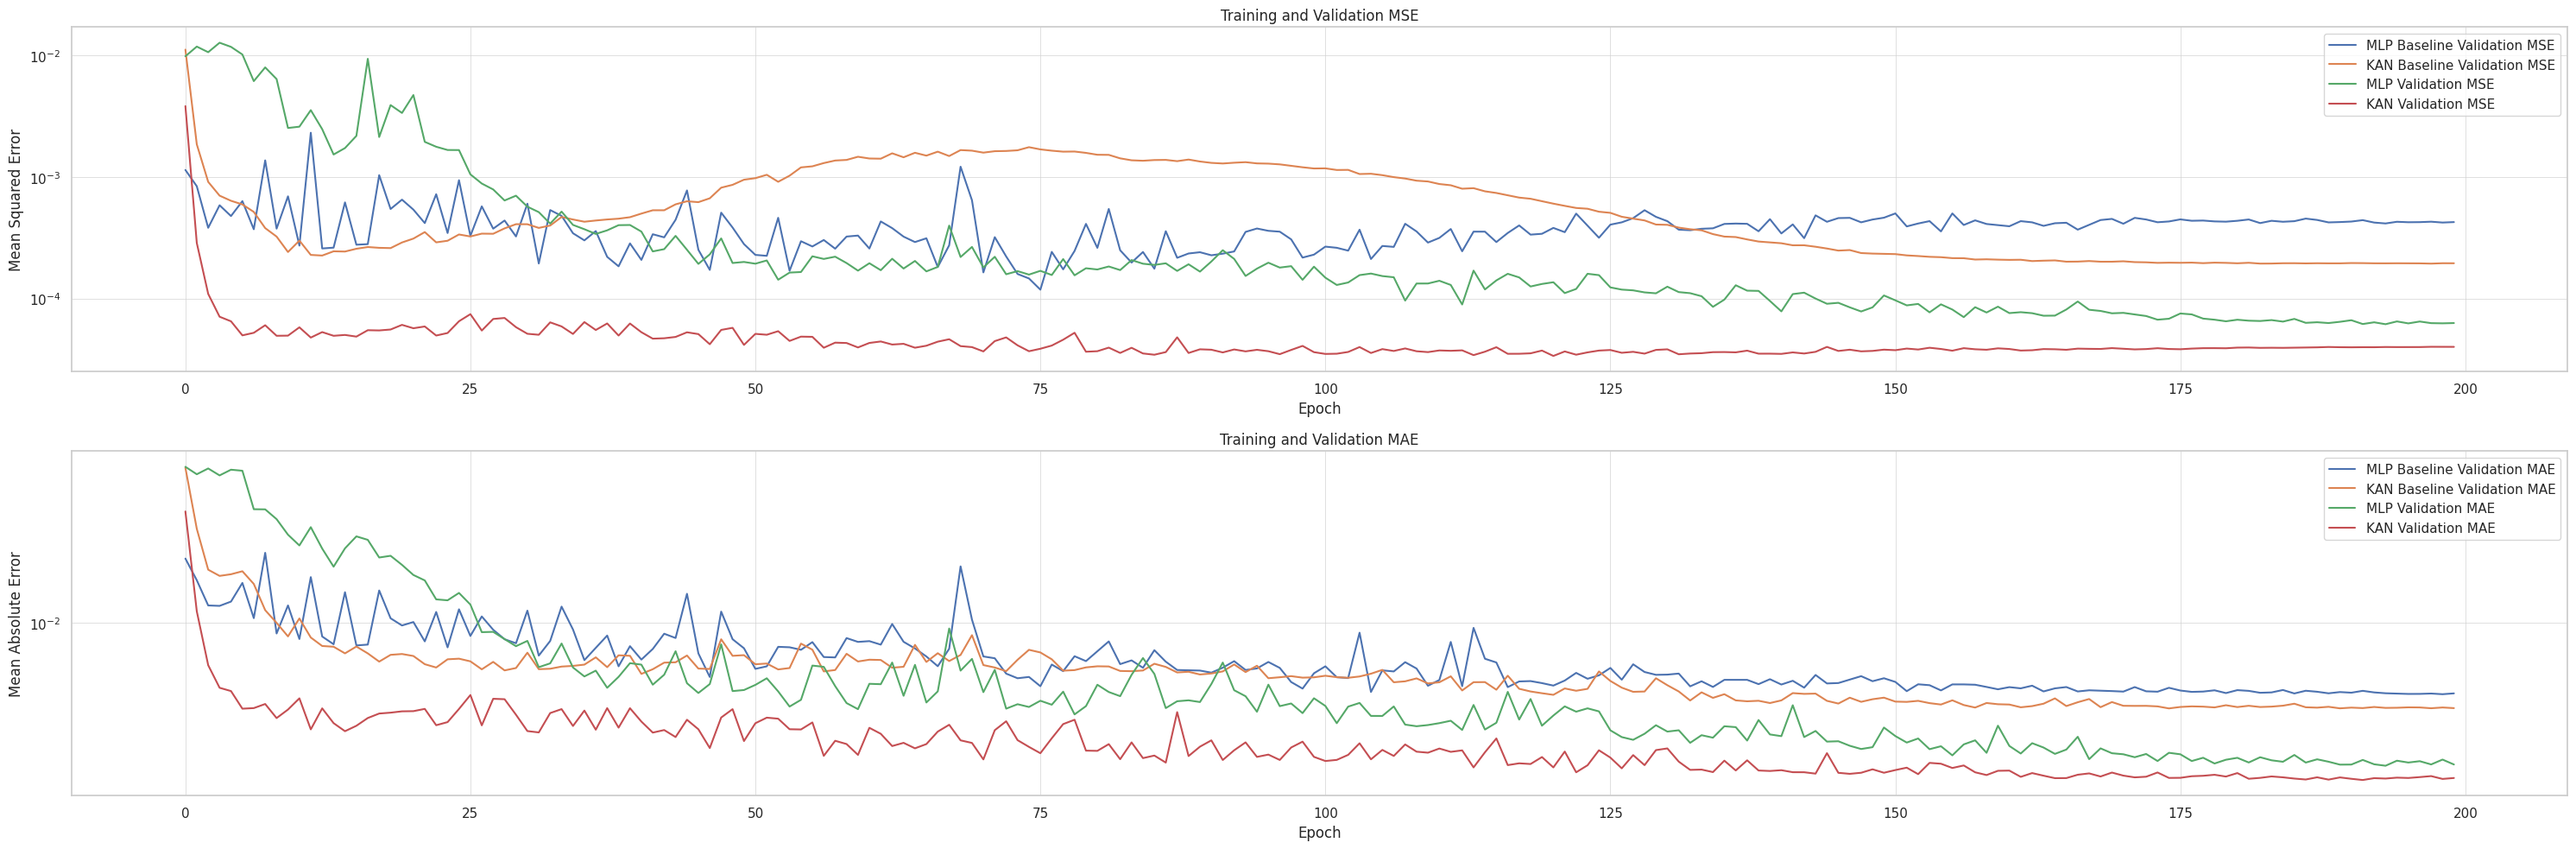

In [23]:
plt.figure(figsize=(30, 10))

plt.subplot(2, 1, 1)
plt.plot(history_mlp_baseline.history['val_loss'], label='MLP Baseline Validation MSE')
plt.plot(history_kan_baseline.history['val_loss'], label='KAN Baseline Validation MSE')
plt.plot(history_mlp.history['val_loss'], label='MLP Validation MSE')
plt.plot(history_kan.history['val_loss'], label='KAN Validation MSE')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)

plt.subplot(2, 1, 2)
plt.plot(history_mlp_baseline.history['val_mae'], label='MLP Baseline Validation MAE')
plt.plot(history_kan_baseline.history['val_mae'], label='KAN Baseline Validation MAE')
plt.plot(history_mlp.history['val_mae'], label='MLP Validation MAE')
plt.plot(history_kan.history['val_mae'], label='KAN Validation MAE')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()